In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [2]:
control_df = pd.read_csv("../Dataset/train_radiomics_occipital_CONTROL.csv")
train_df = pd.read_csv("../Dataset/train_radiomics_hipocamp.csv")
test_df = pd.read_csv("../Dataset/test_radiomics_hipocamp.csv")
dummy_df = pd.read_csv("../Dataset/dummy_submission.csv")

# Data Exploration and Preprocessing

## Matplotlib Plots

In [3]:
def show_histogram(df,title="histogram"):
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.17)
    plt.title(title)
    sns.histplot(df)
    plt.show()

In [4]:
def show_pie(df,title="pie"):
    labels = df.unique().tolist()
    counts = df.value_counts()
    sizes = [counts[var_cat] for var_cat in labels]
    _, ax1 = plt.subplots()
    ax1.pie(sizes, labels=labels, autopct="%1.1f%%",shadow=True)
    ax1.axis("equal")
    plt.title(title)
    plt.show()

In [5]:
def show_boxplot(df,title="boxplot"):
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.17)
    df.boxplot()
    plt.xticks(rotation=15)
    plt.title(title)
    plt.show()


In [6]:
def show_heatmap(df,title="correlation heatmap"):
    df = df.select_dtypes(include="number")
    plt.figure(figsize=(13,8))
    plt.subplots_adjust(bottom=0.25,left=0.22,right=0.95)
    plt.xticks(rotation=15)
    plt.title(title)
    sns.heatmap(df.corr(),annot=True,cmap="coolwarm",linewidths=0.5)
    plt.show()

In [7]:
def show_jointplot(df,x_label,y_label,title="jointplot",hue="Transition_code"):
    sns.jointplot(data=df,x=x_label,y=y_label,hue=hue)
    plt.show()

In [8]:
def show_catplot(df, x_label, y_label, title="catplot", hue="Transition_code"):
    sns.catplot(data=df, x=x_label, y=y_label, hue=hue)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()

In [9]:
def show_pairplot(df,hue="Transition_code"):
    sns.pairplot(df,hue=hue)
    plt.show()

## Outliers

In [10]:
def explore_outliers(df,columns):
    number_df = df[columns].select_dtypes(include="number")
    n_columns = number_df.columns
    # normalização para ser visualmente perceptivel nos plots
    scaler = MinMaxScaler()
    number_df_scaled = pd.DataFrame(scaler.fit_transform(number_df),columns=n_columns)

    for i in range(0, len(n_columns),7):
        show_boxplot(df=number_df_scaled[n_columns[i:i+7]])
        
# esta função faz um loop de 7 em 7 colunas por todas as colunas do dataset para uma analise geral dos outliers.
# esta operacao é demorada e nao muito boa porque 2181 / 7 = 300 vezes


In [11]:
def detect_outliers(df,column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtrar os outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

    show_boxplot(title=f"{column} boxplot",df=df[[column]])

    print(outliers[column])

# IQR method 
## considera como outliers os dados que estao 1.5*IQR acima e abaixo do primeiro e terceiro quartil, respetivamente. IQR = Q3 - Q1

## Category Encoder and Decoder
bastante útil para poder codificar e posteriormente decodificar categorical features

In [12]:
def target_encoder(df, target="Transition"):
    le_make = LabelEncoder()
    df[f"{target}_code"] = le_make.fit_transform(df[target])
    return le_make

def target_decoder(le_make, preds):
    return le_make.inverse_transform(preds)


In [13]:
le_make_train = target_encoder(train_df)
le_make_control = target_encoder(control_df)

## Basic Exploration

In [14]:
def main_exploration(df):
    print(df.shape) 

In [15]:
main_exploration(control_df)
main_exploration(train_df)
main_exploration(test_df)

(305, 2182)
(305, 2182)
(100, 2180)


In [16]:
def numerical_exploration(df):
    # age exploration
    show_histogram(df["Age"],title="Histogram")
    print(df["Age"].describe())
    detect_outliers(df,"Age")

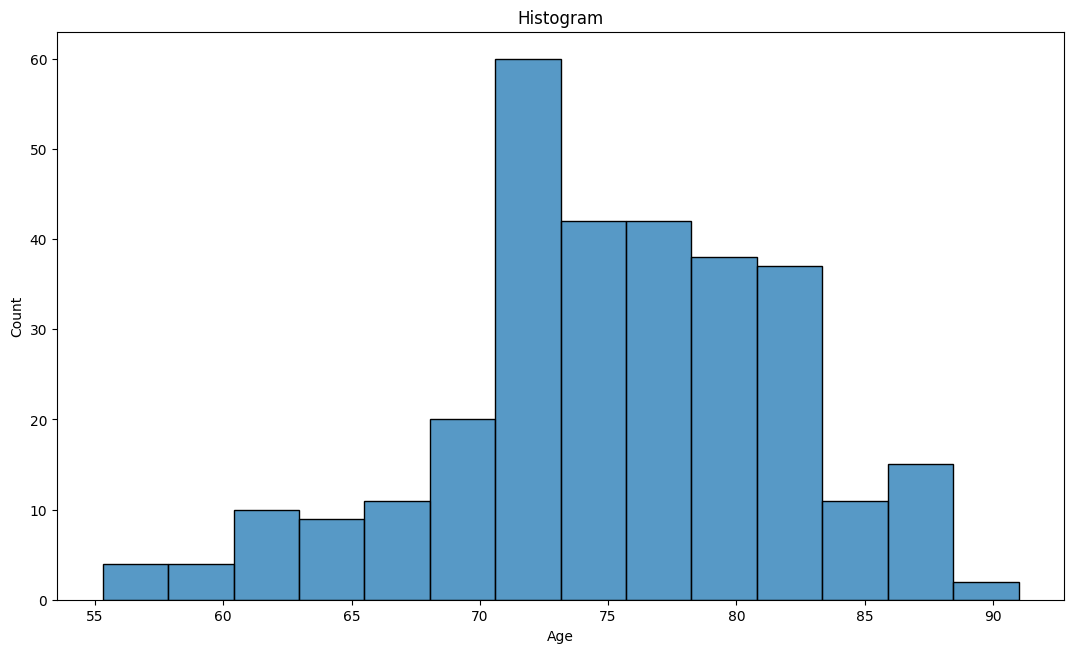

count    305.000000
mean      75.171148
std        6.675866
min       55.300000
25%       71.300000
50%       75.000000
75%       79.900000
max       91.000000
Name: Age, dtype: float64


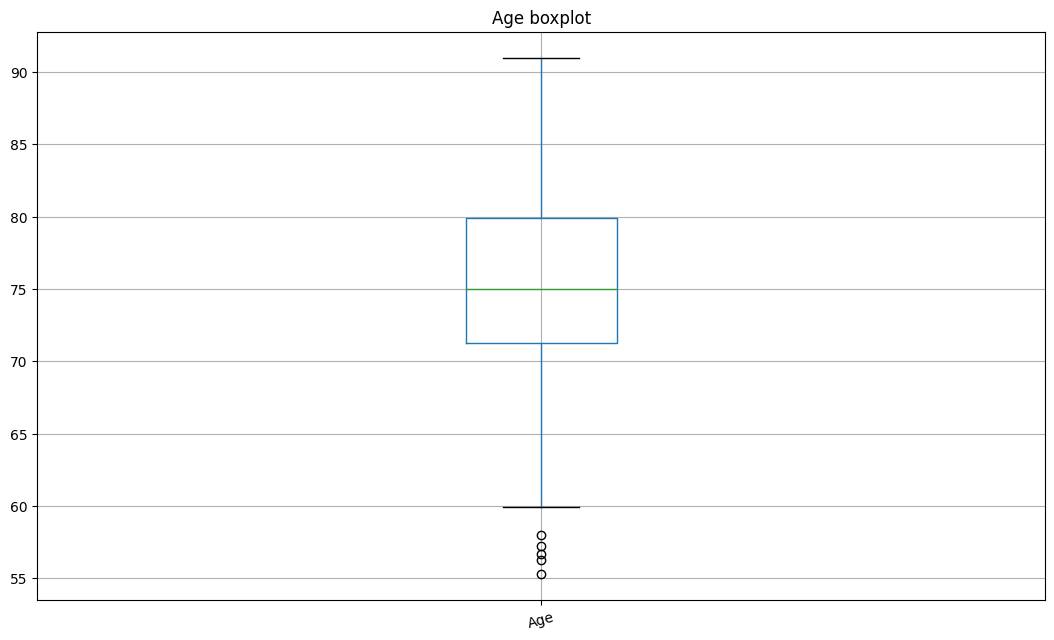

41     55.3
106    57.2
147    56.3
248    58.0
292    56.7
Name: Age, dtype: float64


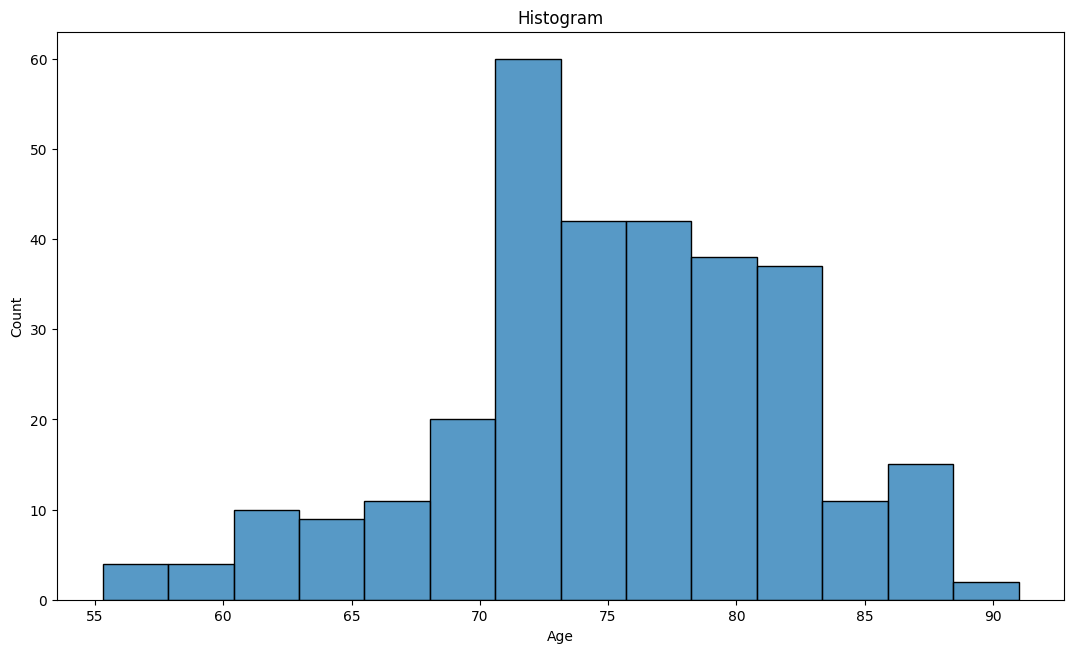

count    305.000000
mean      75.171148
std        6.675866
min       55.300000
25%       71.300000
50%       75.000000
75%       79.900000
max       91.000000
Name: Age, dtype: float64


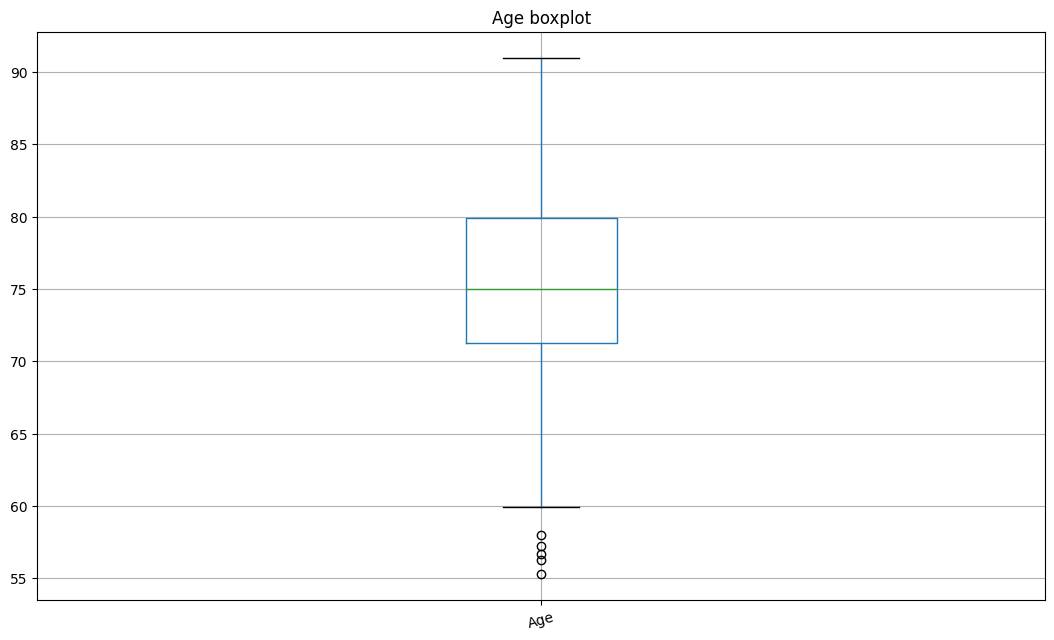

41     55.3
106    57.2
147    56.3
248    58.0
292    56.7
Name: Age, dtype: float64


In [17]:
numerical_exploration(control_df)
numerical_exploration(train_df)

In [18]:
def categorical_exploration(df):
    """
    Transition description:
    CN - Cognitive Normal, estado normal
    MCI - Mild Cognitive Impairment, estado entre o avanço normal da perda de memoria com a idade e um certo declinio serio de demencia
    AD - Azlheimer Disease, forma mais comum de demencia nas pessoas mais velhas
    """
    categorical_df = df[["Sex","Transition"]]

    for column in categorical_df.columns:
        show_histogram(categorical_df[column],title=f"{column} histogram")
        print(df[column].value_counts())


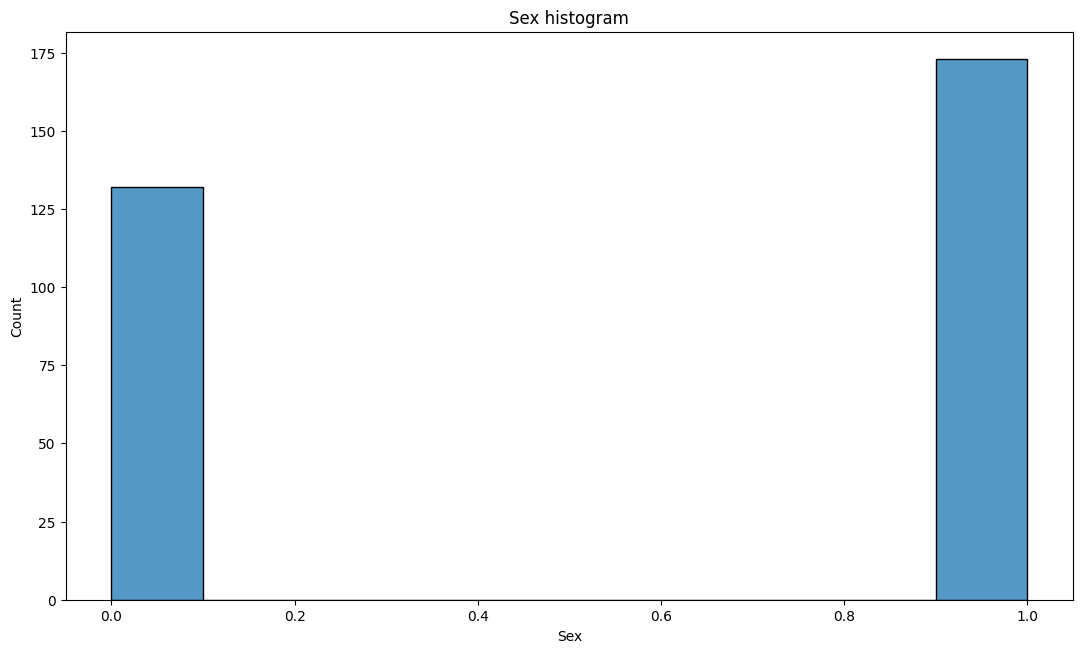

Sex
1    173
0    132
Name: count, dtype: int64


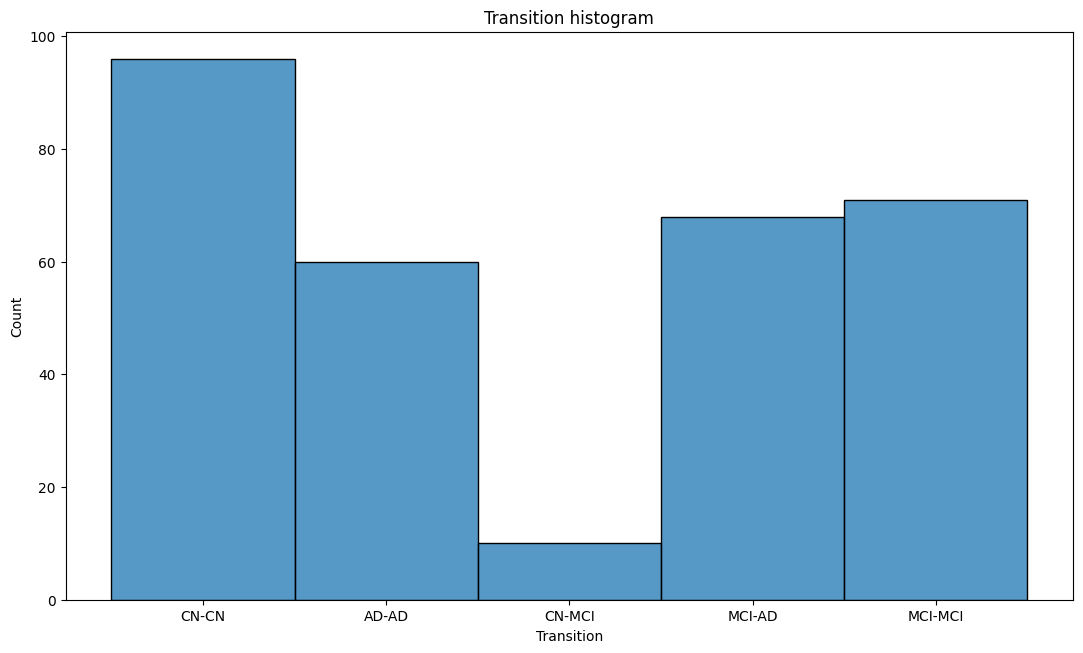

Transition
CN-CN      96
MCI-MCI    71
MCI-AD     68
AD-AD      60
CN-MCI     10
Name: count, dtype: int64


In [19]:
categorical_exploration(train_df)

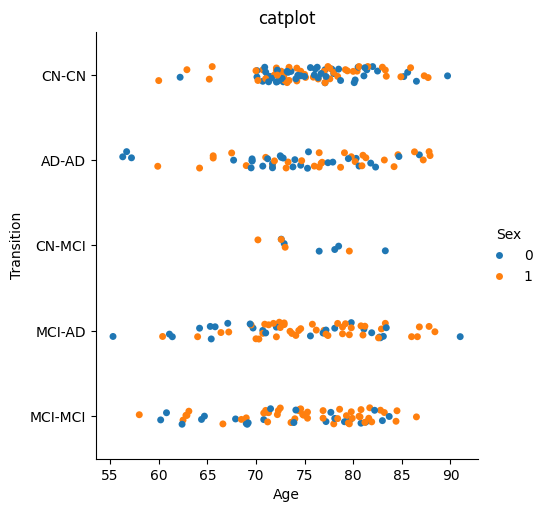

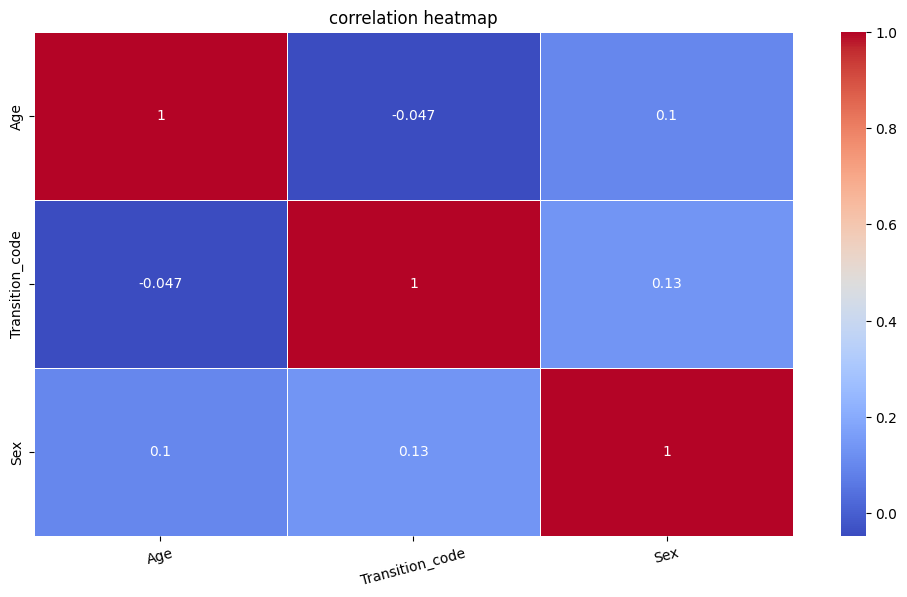

In [20]:
show_catplot(train_df, "Age", "Transition", hue="Sex")
show_heatmap(train_df[["Age","Transition_code","Sex"]])

<Axes: >

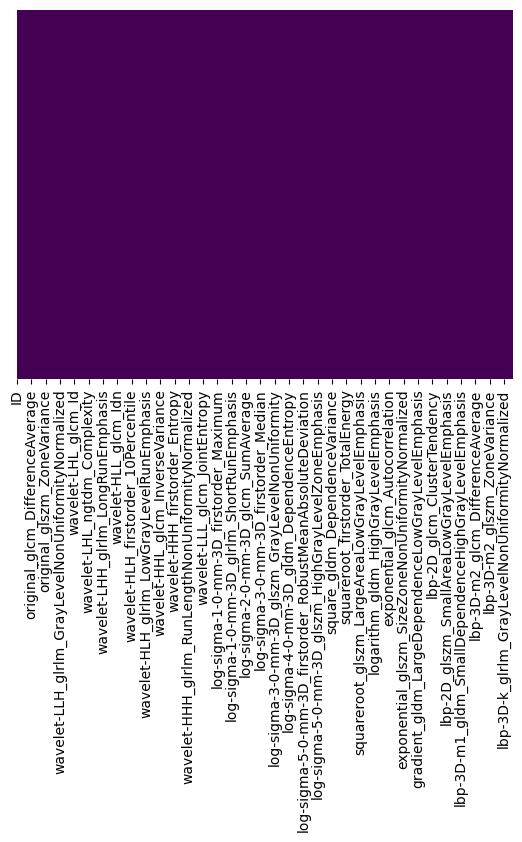

In [21]:
sns.heatmap(train_df.isnull(), yticklabels=False, cbar=False, cmap="viridis")

## Diagnostic Exploration

In [22]:
diagnostics_configs_columns = ["diagnostics_Configuration_Settings","diagnostics_Configuration_EnabledImageTypes"]
def diagnostics_configs(df):
    for col in diagnostics_configs_columns:
        print(len(df[col].unique()))

In [23]:
diagnostics_configs(control_df)
diagnostics_configs(train_df)

1
1
1
1


In [24]:
diagnostics_versions_columns = ["diagnostics_Versions_PyRadiomics","diagnostics_Versions_Numpy","diagnostics_Versions_SimpleITK","diagnostics_Versions_PyWavelet","diagnostics_Versions_Python"] 
def diagnostics_versions_explorer(df):
    for column in diagnostics_versions_columns:
        print(column,": ")
        values = df[column].unique()
        print(values)

In [25]:
diagnostics_versions_explorer(control_df)
diagnostics_versions_explorer(train_df)

diagnostics_Versions_PyRadiomics : 
['2.2.0']
diagnostics_Versions_Numpy : 
['1.18.5']
diagnostics_Versions_SimpleITK : 
['1.2.4']
diagnostics_Versions_PyWavelet : 
['1.1.1']
diagnostics_Versions_Python : 
['3.7.7']
diagnostics_Versions_PyRadiomics : 
['2.2.0']
diagnostics_Versions_Numpy : 
['1.18.5']
diagnostics_Versions_SimpleITK : 
['1.2.4']
diagnostics_Versions_PyWavelet : 
['1.1.1']
diagnostics_Versions_Python : 
['3.7.7']


In [26]:
diagnostics_image_columns = ["diagnostics_Image-original_Mean","diagnostics_Image-original_Minimum","diagnostics_Image-original_Maximum"]
def diagnostics_image_explorer(df):

    for column in diagnostics_image_columns:
        show_histogram(df=df[column],title=column)

    explore_outliers(df,diagnostics_image_columns)

    print(df[diagnostics_image_columns].describe())
    print(df[diagnostics_image_columns].info())
    

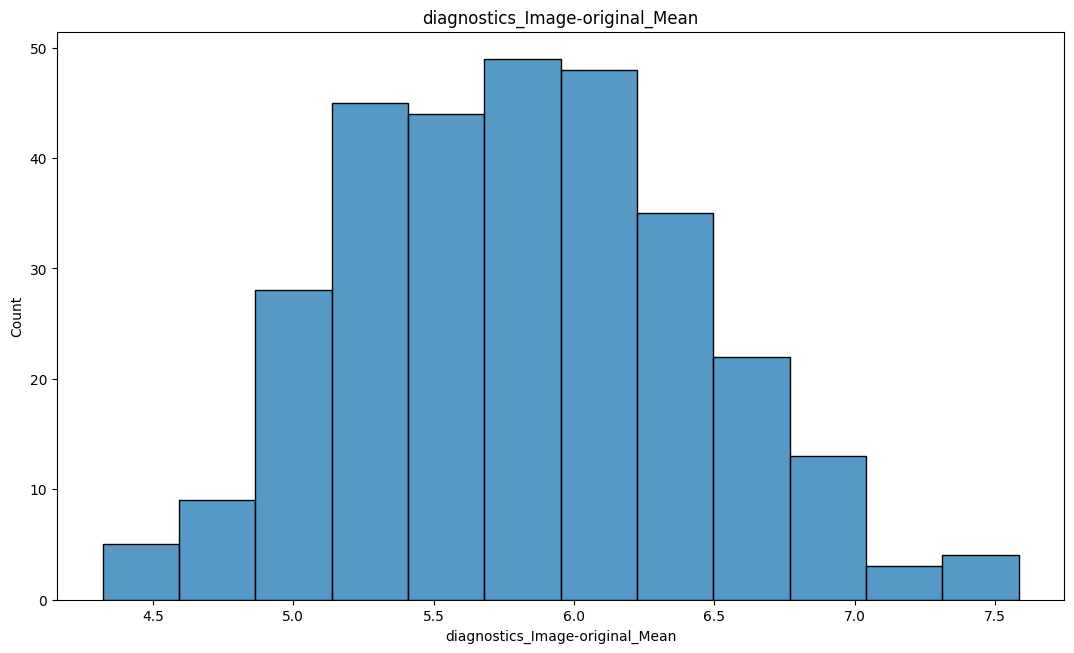

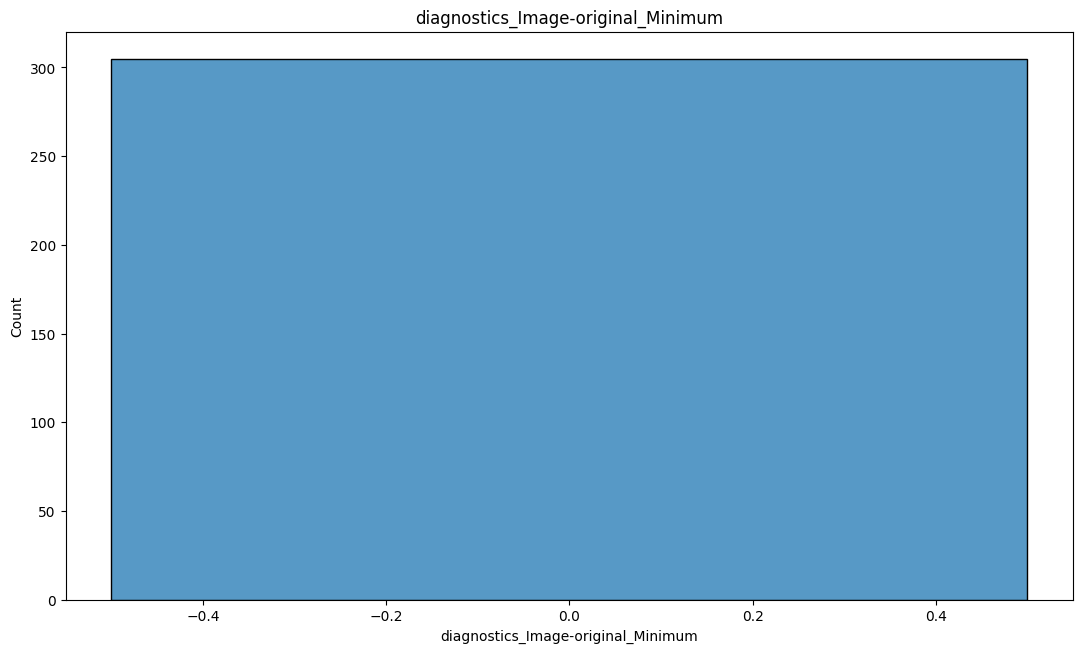

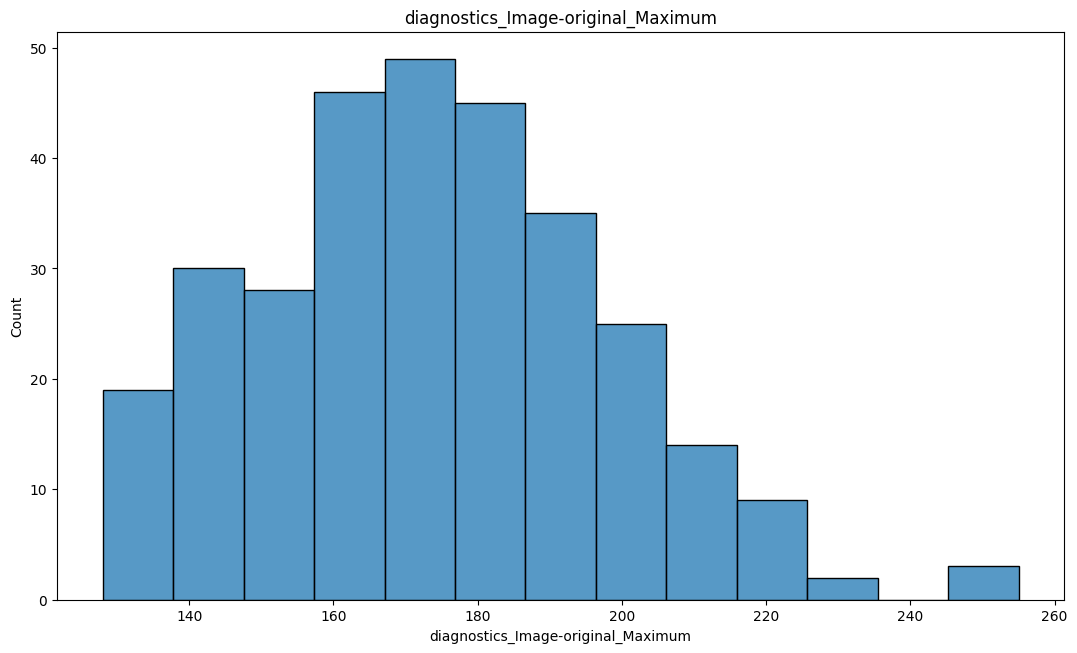

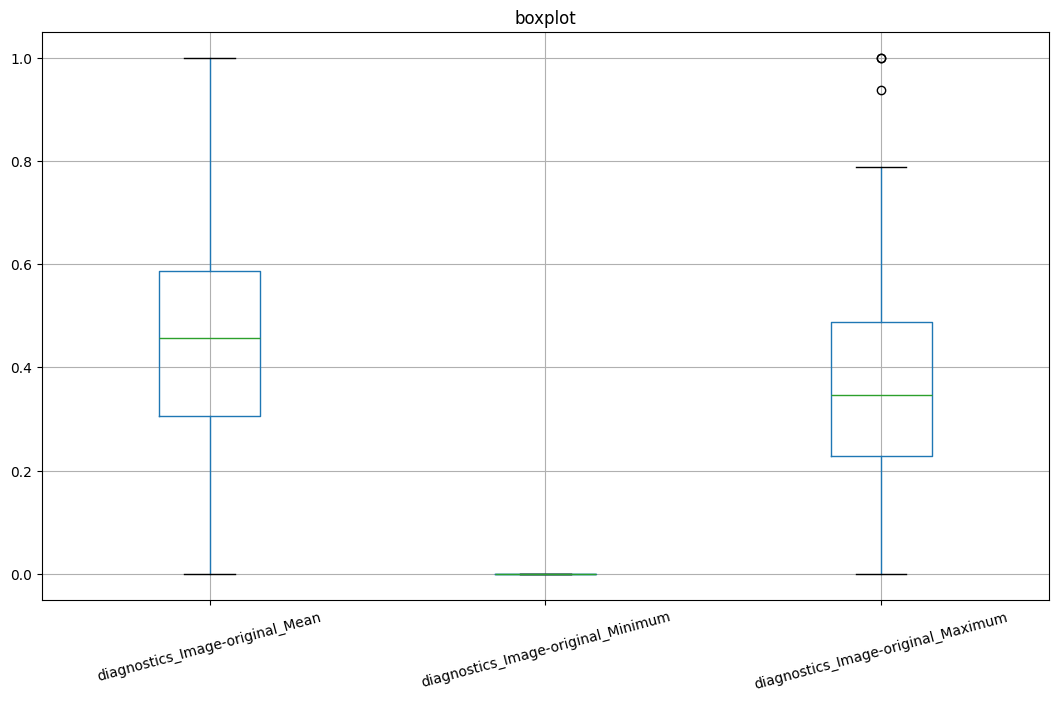

       diagnostics_Image-original_Mean  diagnostics_Image-original_Minimum  \
count                       305.000000                               305.0   
mean                          5.810469                                 0.0   
std                           0.613858                                 0.0   
min                           4.321602                                 0.0   
25%                           5.317298                                 0.0   
50%                           5.811449                                 0.0   
75%                           6.237751                                 0.0   
max                           7.583210                                 0.0   

       diagnostics_Image-original_Maximum  
count                          305.000000  
mean                           173.504918  
std                             24.108871  
min                            128.000000  
25%                            157.000000  
50%                            17

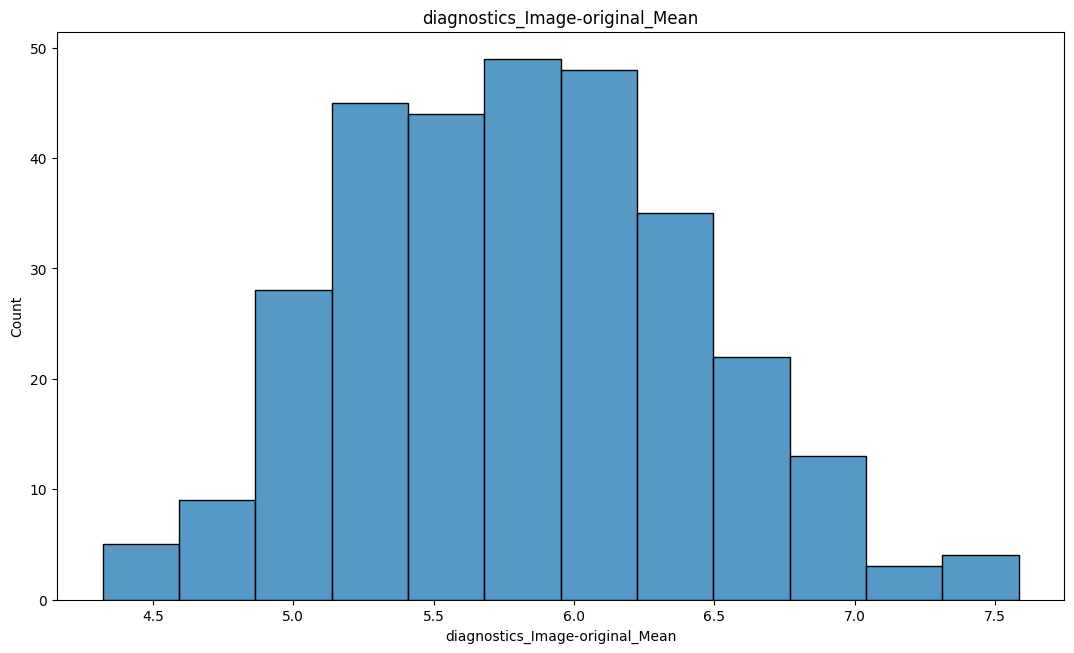

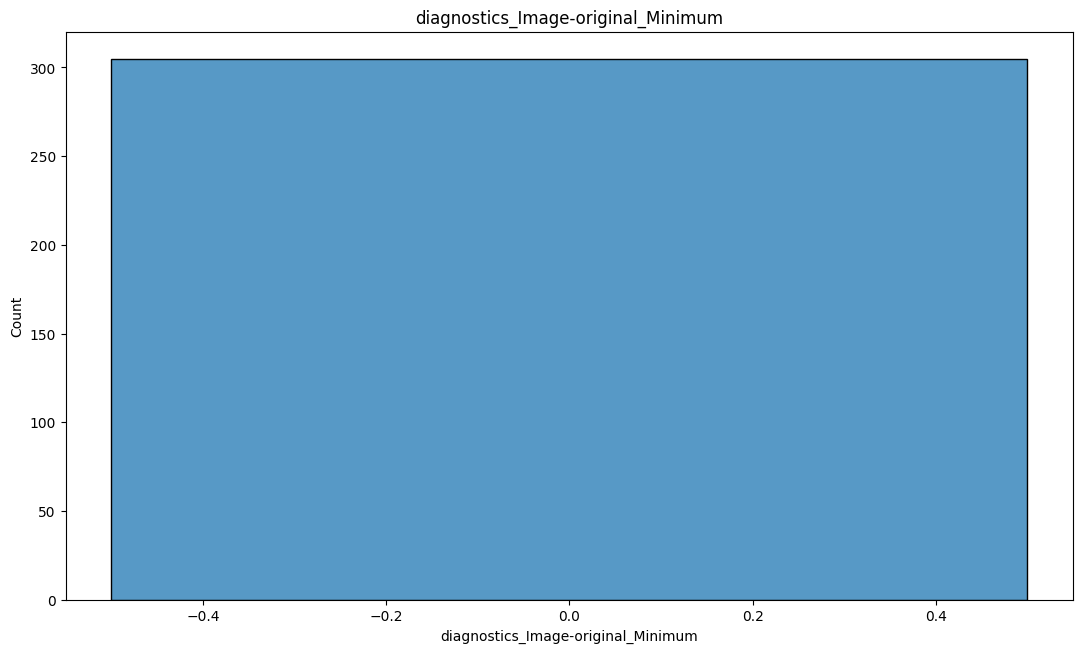

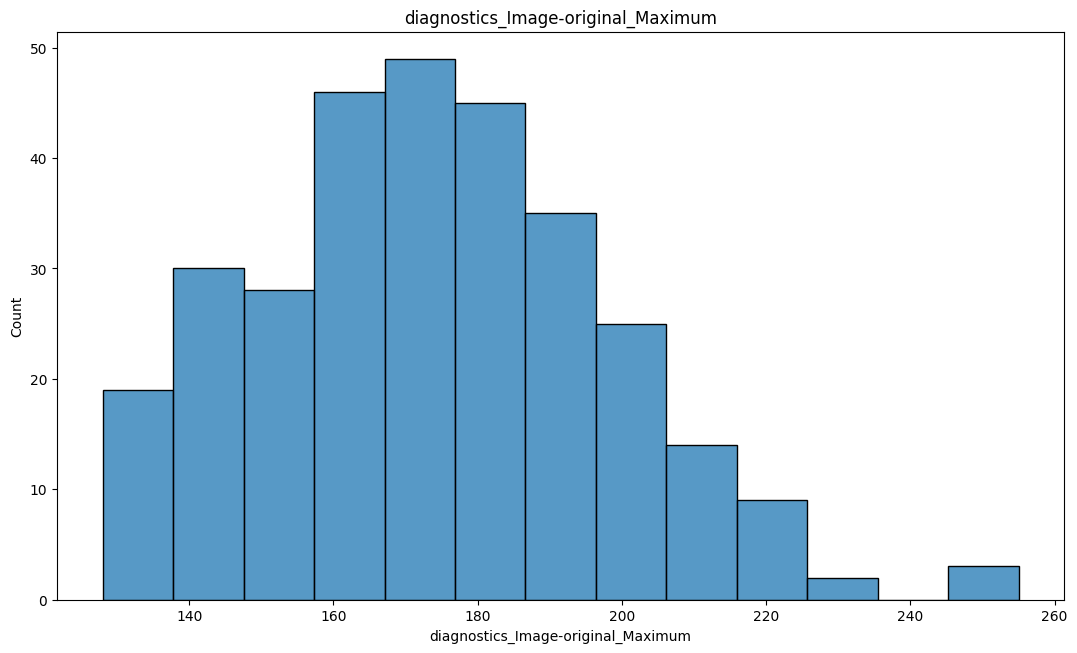

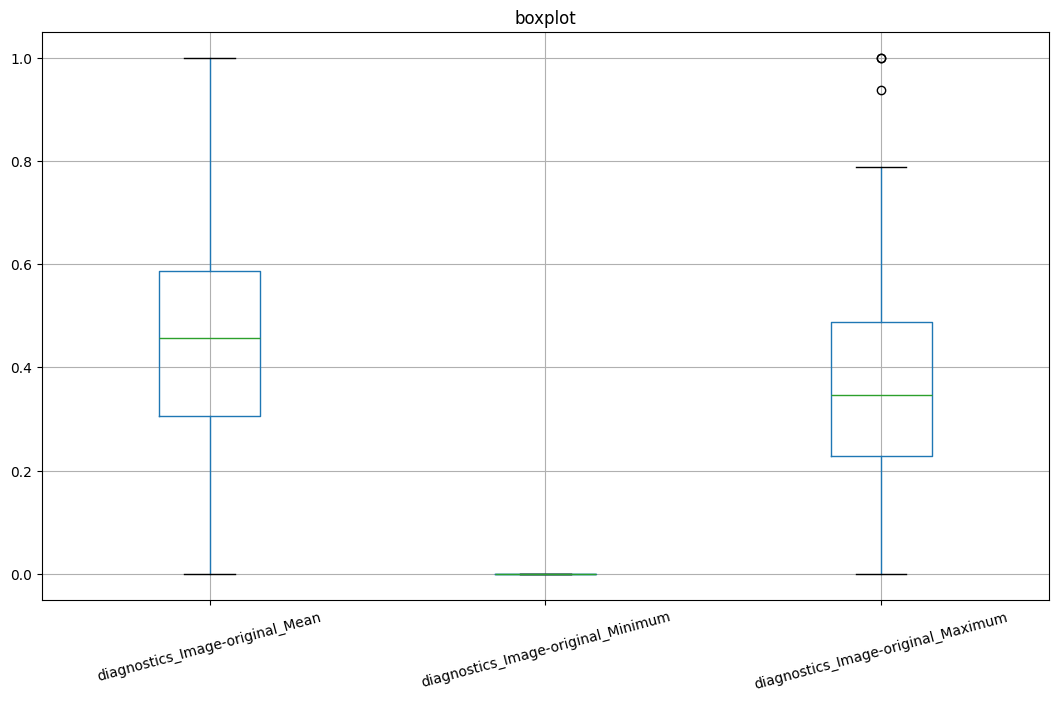

       diagnostics_Image-original_Mean  diagnostics_Image-original_Minimum  \
count                       305.000000                               305.0   
mean                          5.810469                                 0.0   
std                           0.613858                                 0.0   
min                           4.321602                                 0.0   
25%                           5.317298                                 0.0   
50%                           5.811449                                 0.0   
75%                           6.237751                                 0.0   
max                           7.583210                                 0.0   

       diagnostics_Image-original_Maximum  
count                          305.000000  
mean                           173.504918  
std                             24.108871  
min                            128.000000  
25%                            157.000000  
50%                            17

In [27]:
diagnostics_image_explorer(control_df)
diagnostics_image_explorer(train_df)

In [28]:
diagnostics_mask_columns = ["diagnostics_Mask-original_BoundingBox","diagnostics_Mask-original_VoxelNum","diagnostics_Mask-original_VolumeNum","diagnostics_Mask-original_CenterOfMassIndex","diagnostics_Mask-original_CenterOfMass"]
def diagnostics_mask_explorer(df):

    
    for column in diagnostics_mask_columns:
        print(column,": ")
        values = df[column].unique()
        print(len(values))
        show_histogram(title=column,df=df[column])
    

    detect_outliers(df,"diagnostics_Mask-original_VoxelNum")
    detect_outliers(df,"diagnostics_Mask-original_VolumeNum")
    explore_outliers(df,columns=diagnostics_mask_columns)
    
    print(df[diagnostics_mask_columns].describe(),"\n")
    print(df[diagnostics_mask_columns].info())

diagnostics_Mask-original_BoundingBox : 
305


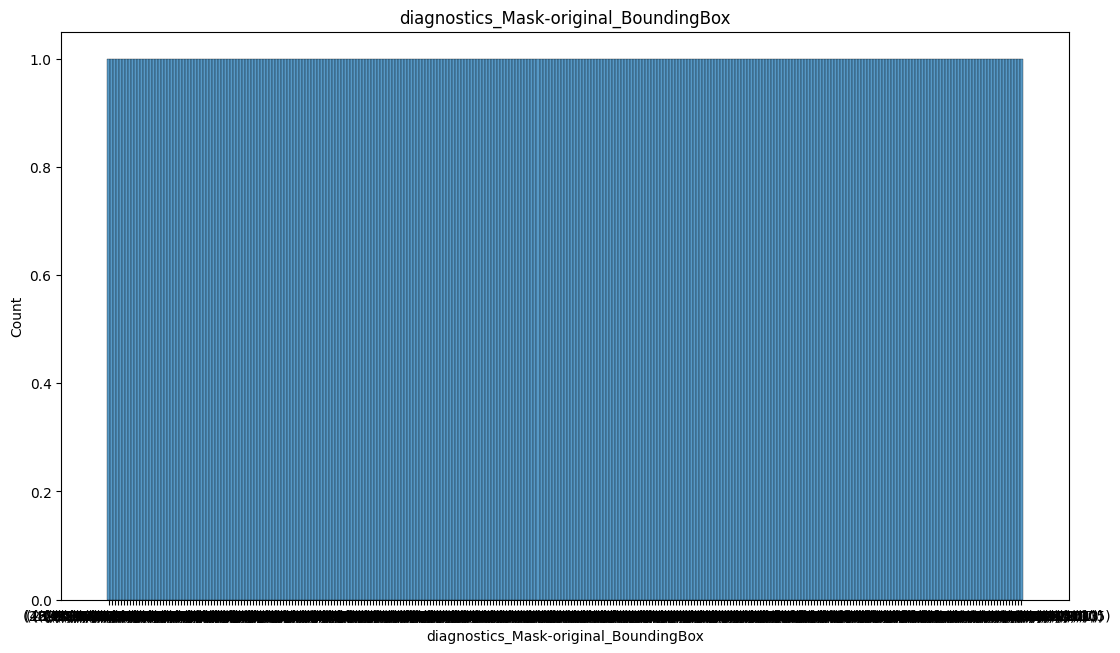

diagnostics_Mask-original_VoxelNum : 
300


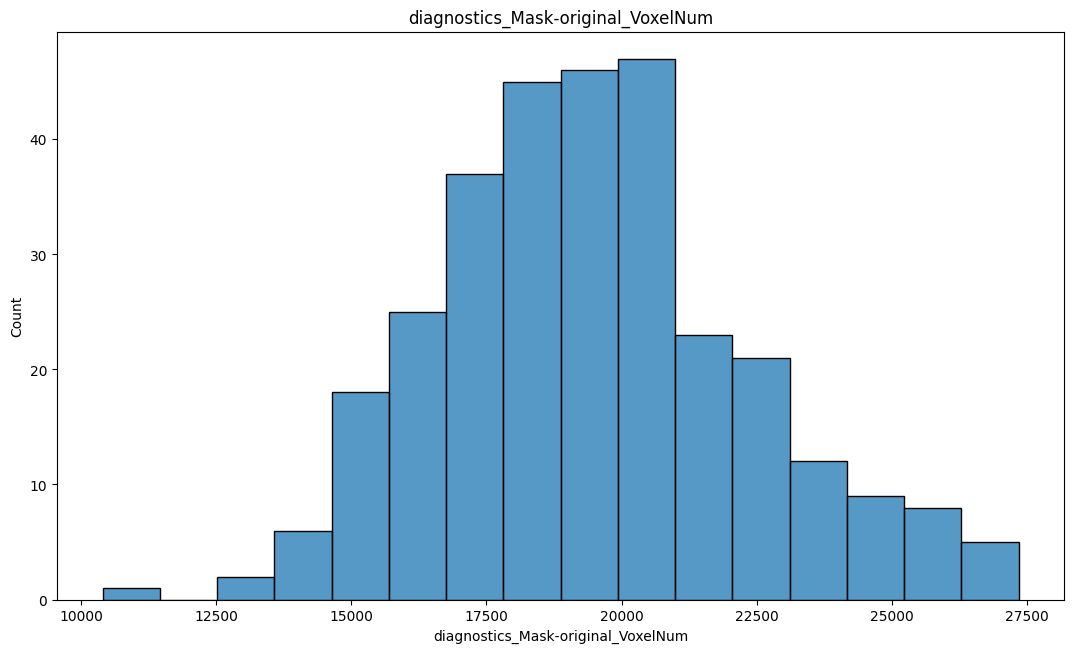

diagnostics_Mask-original_VolumeNum : 
4


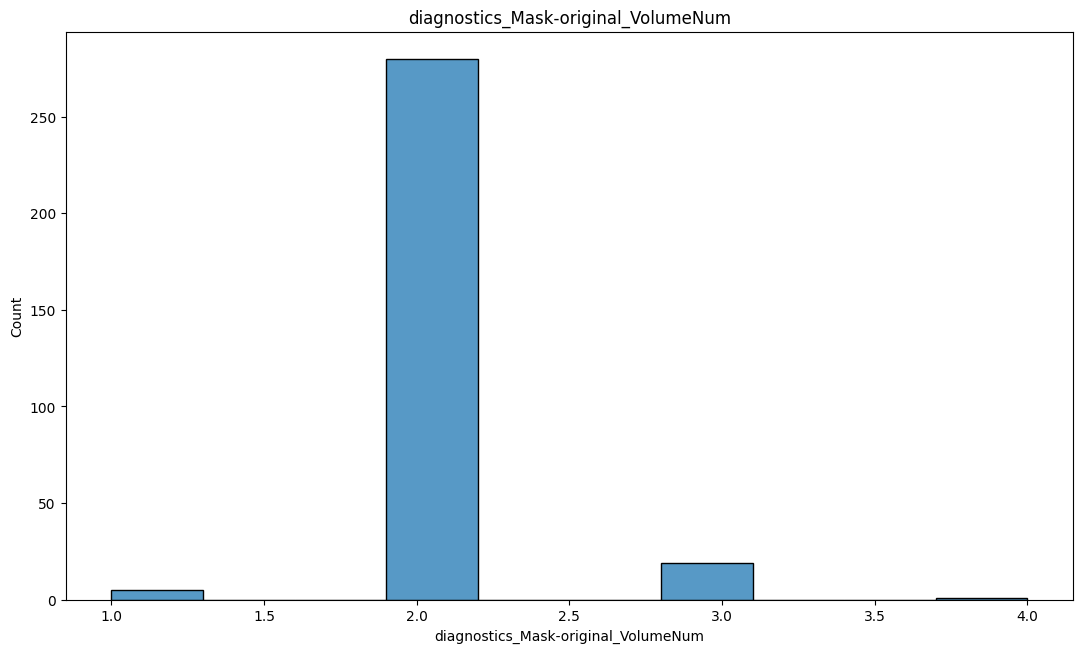

diagnostics_Mask-original_CenterOfMassIndex : 
305


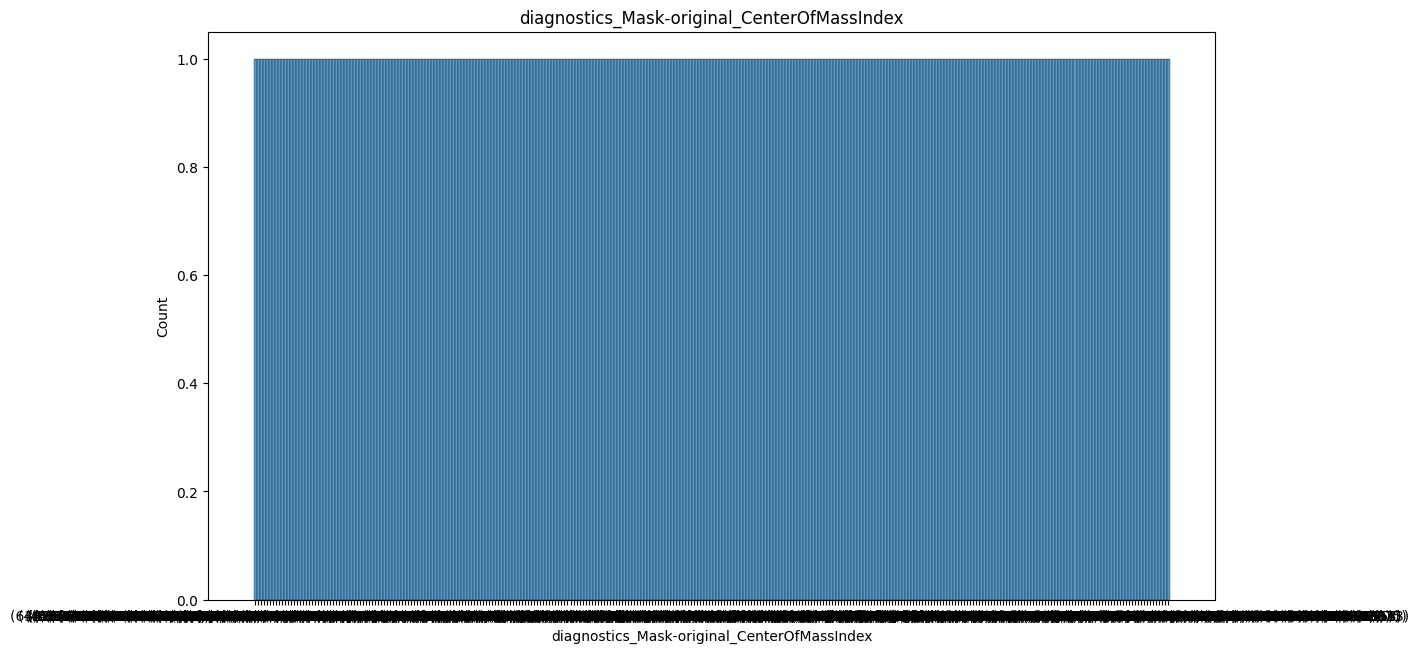

diagnostics_Mask-original_CenterOfMass : 
305


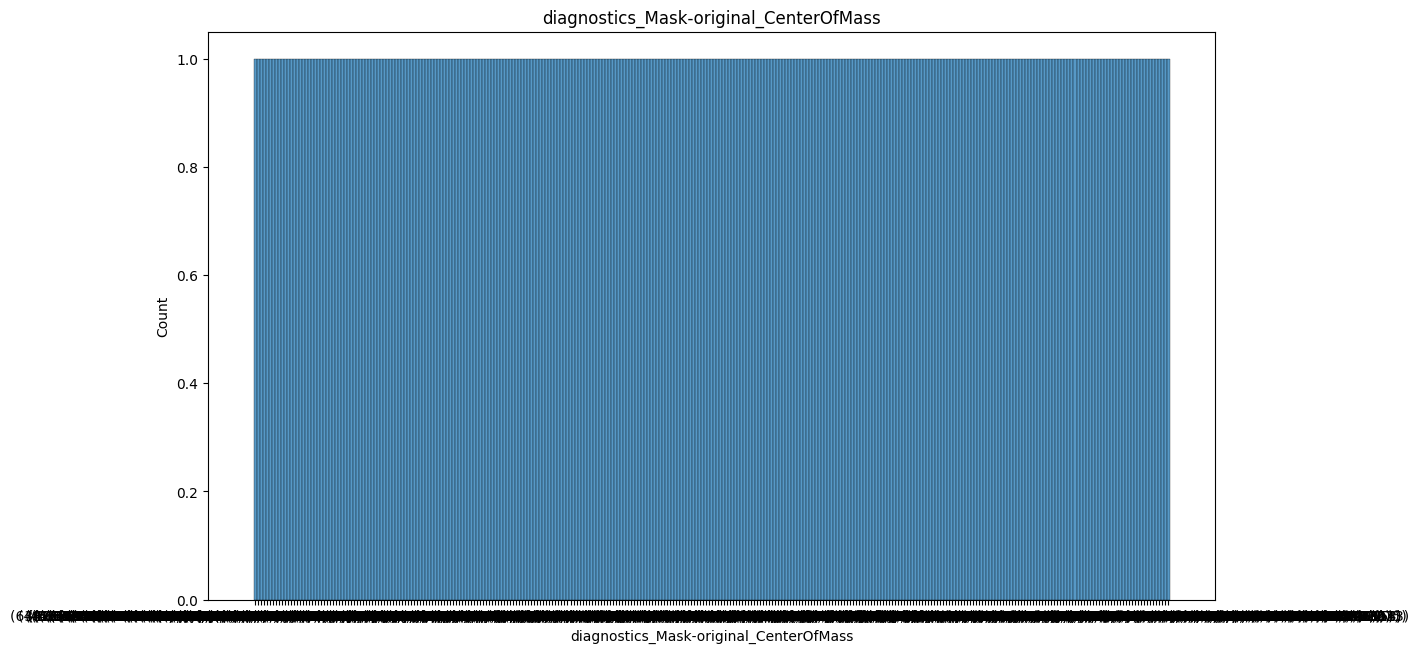

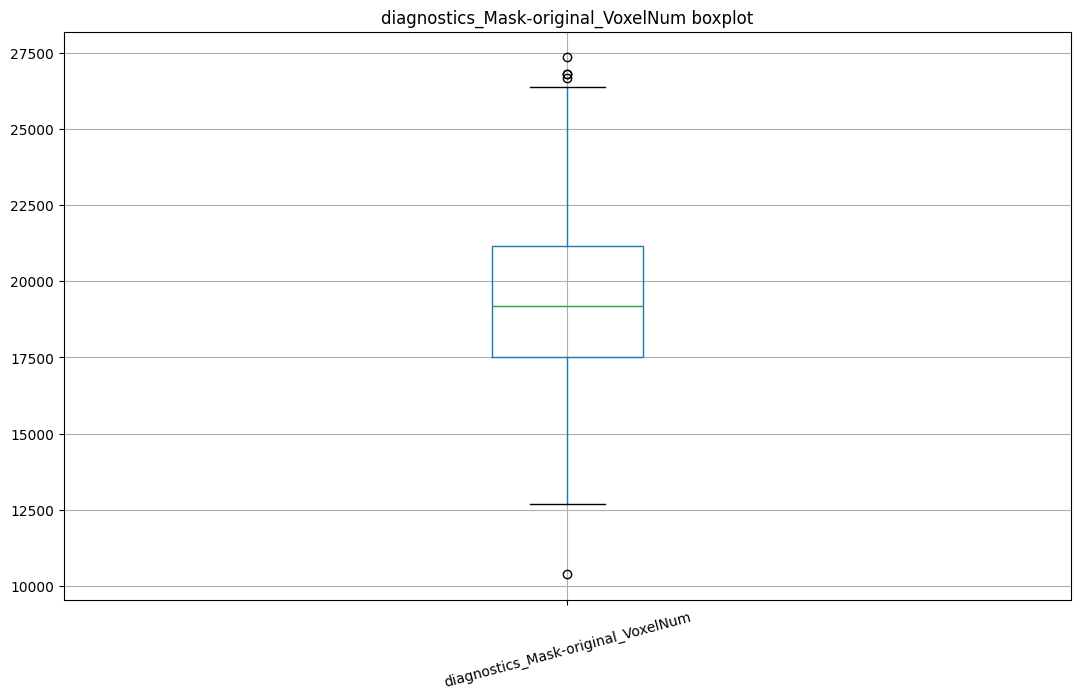

58     26802
109    26668
153    27345
156    26813
174    10400
Name: diagnostics_Mask-original_VoxelNum, dtype: int64


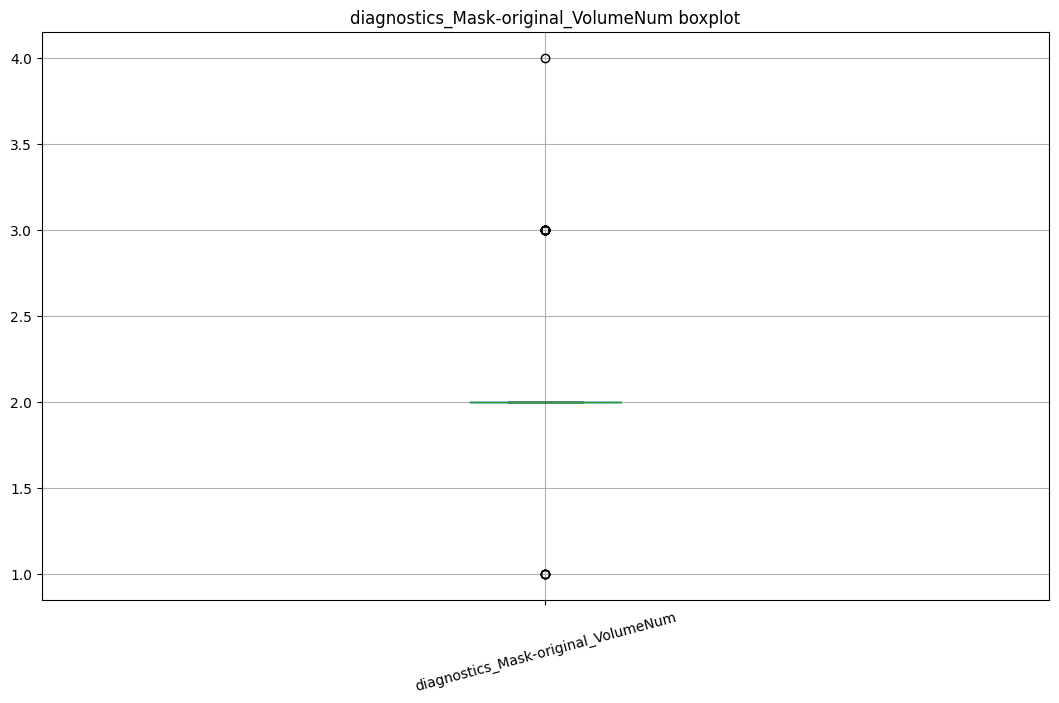

2      4
28     3
38     3
41     3
45     3
59     3
73     1
83     1
89     3
98     3
101    3
112    3
114    1
131    3
141    3
144    1
147    1
148    3
151    3
163    3
230    3
244    3
262    3
274    3
298    3
Name: diagnostics_Mask-original_VolumeNum, dtype: int64


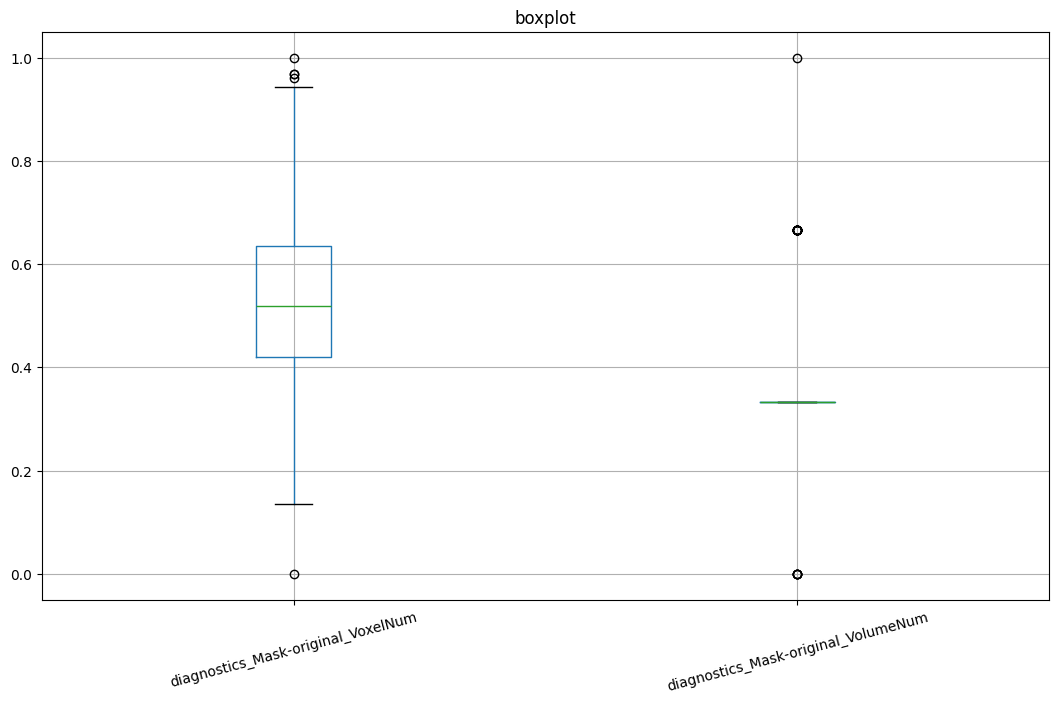

       diagnostics_Mask-original_VoxelNum  diagnostics_Mask-original_VolumeNum
count                          305.000000                           305.000000
mean                         19466.340984                             2.052459
std                           2897.483977                             0.298905
min                          10400.000000                             1.000000
25%                          17521.000000                             2.000000
50%                          19201.000000                             2.000000
75%                          21155.000000                             2.000000
max                          27345.000000                             4.000000 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 5 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   diagnostics_Mask-original_Boundi

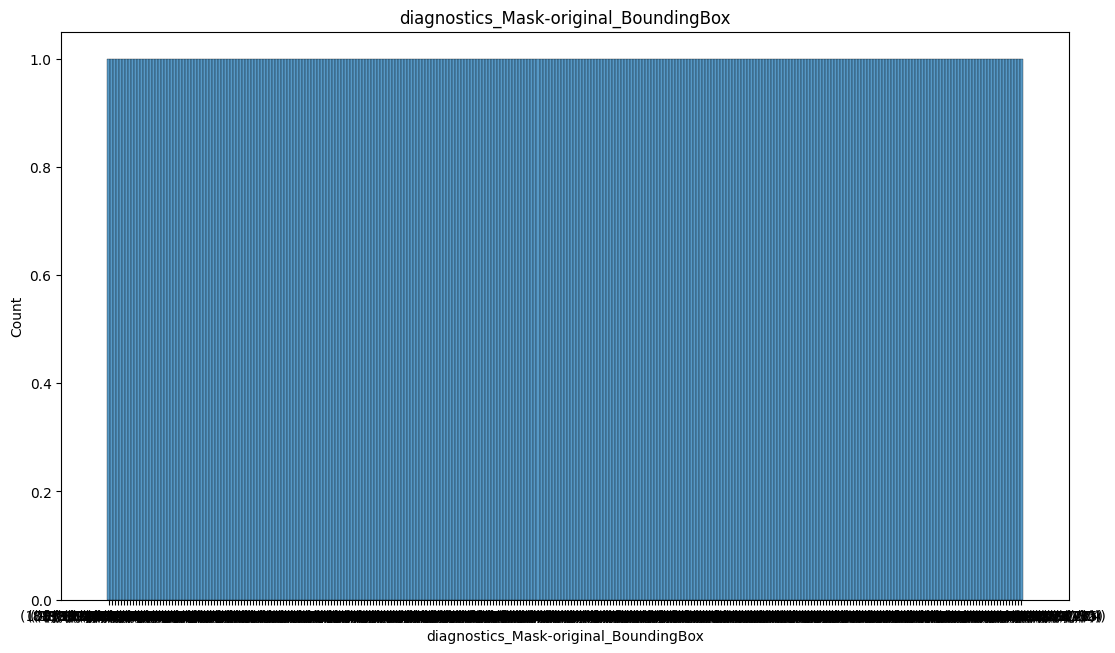

diagnostics_Mask-original_VoxelNum : 
294


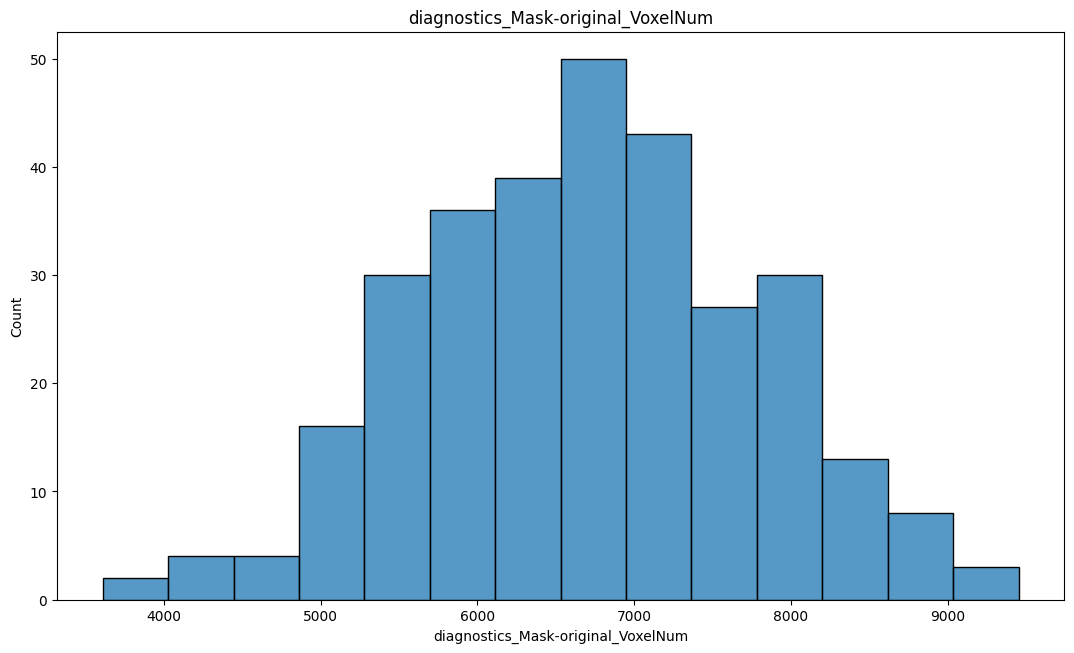

diagnostics_Mask-original_VolumeNum : 
1


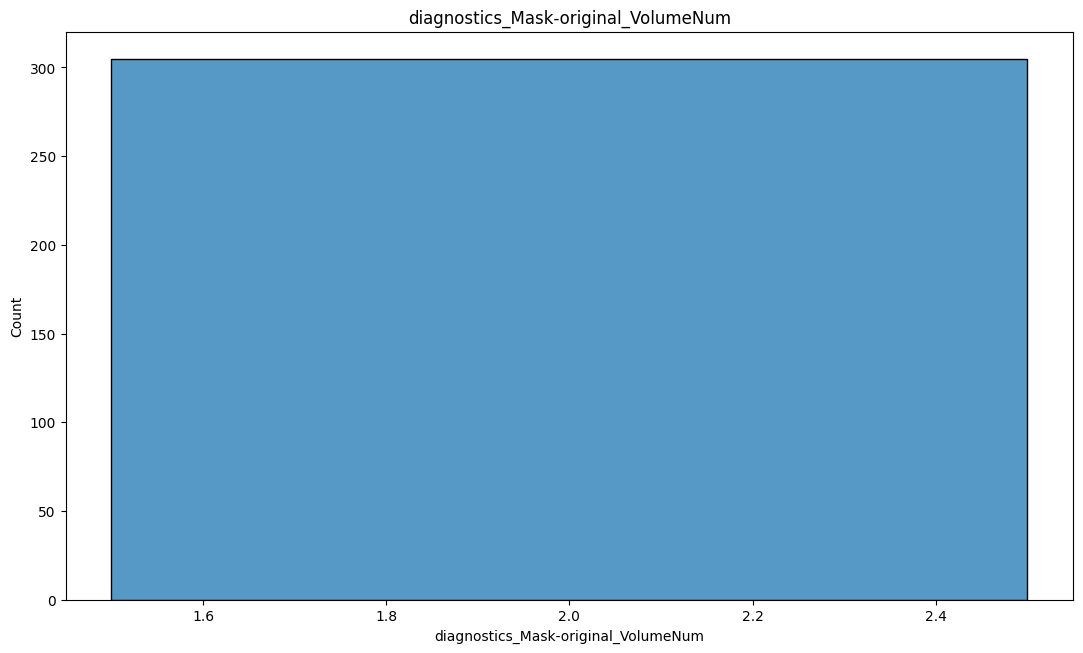

diagnostics_Mask-original_CenterOfMassIndex : 
305


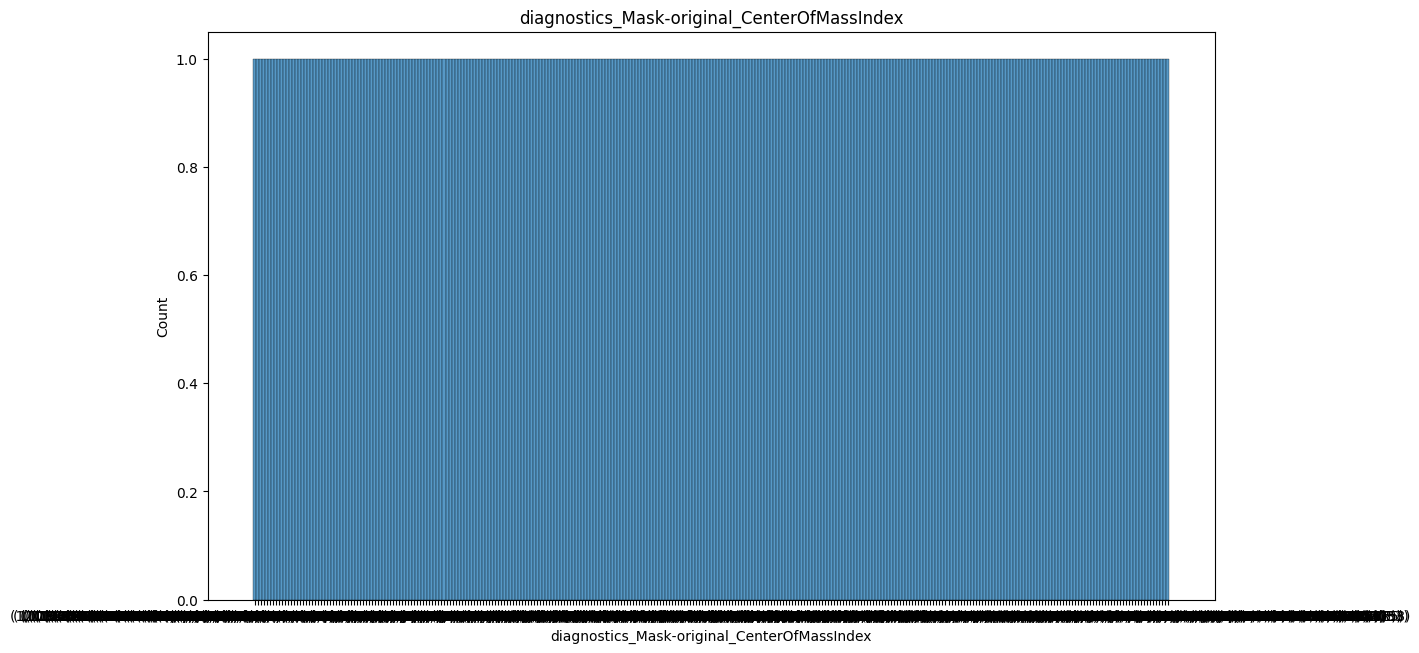

diagnostics_Mask-original_CenterOfMass : 
305


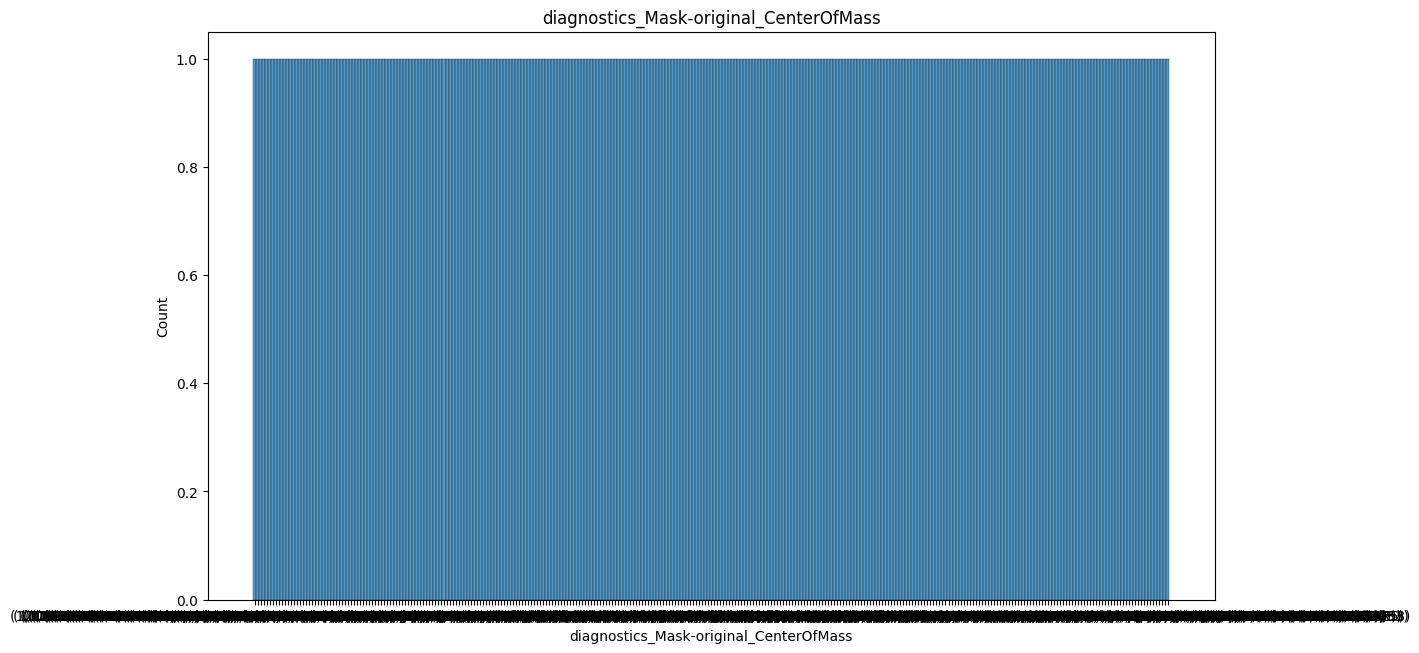

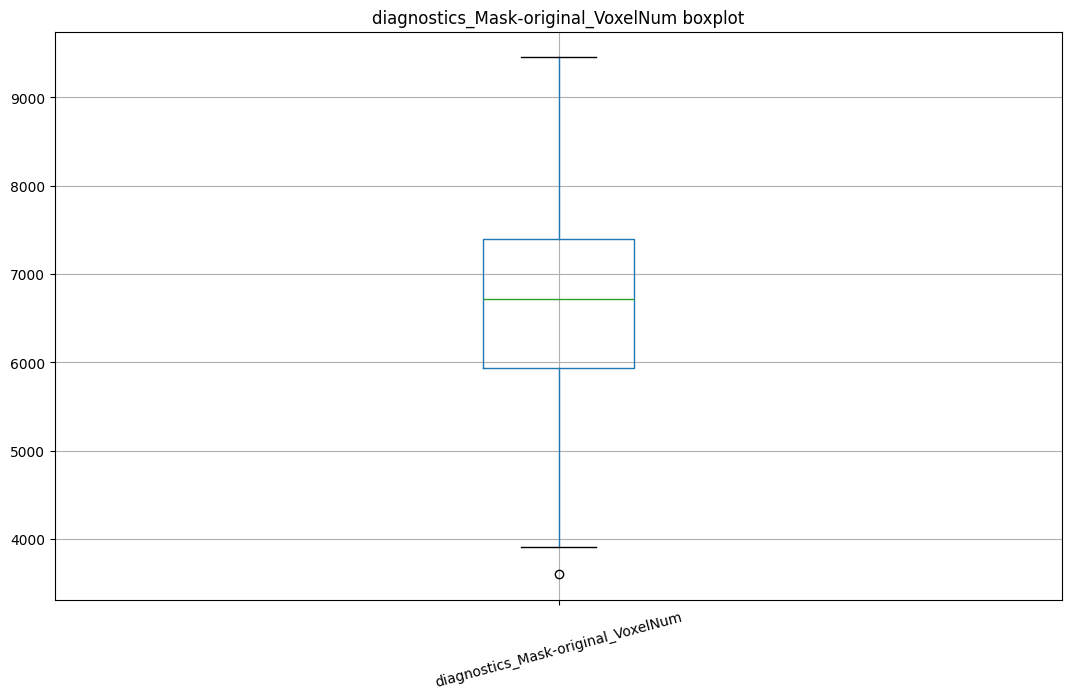

188    3609
Name: diagnostics_Mask-original_VoxelNum, dtype: int64


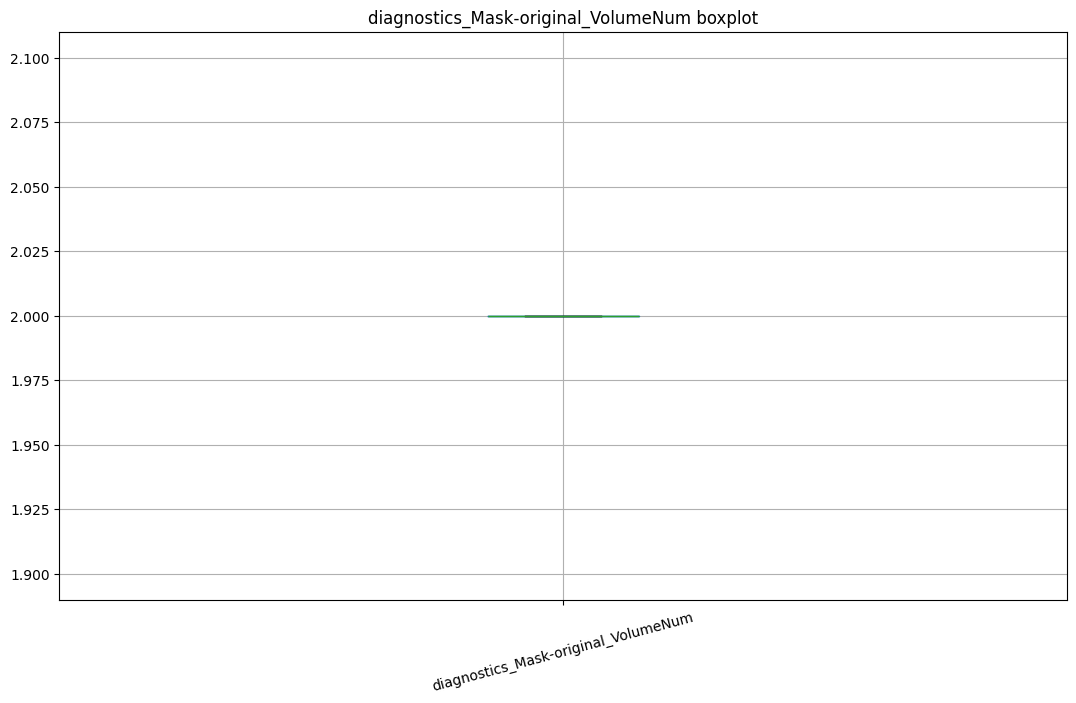

Series([], Name: diagnostics_Mask-original_VolumeNum, dtype: int64)


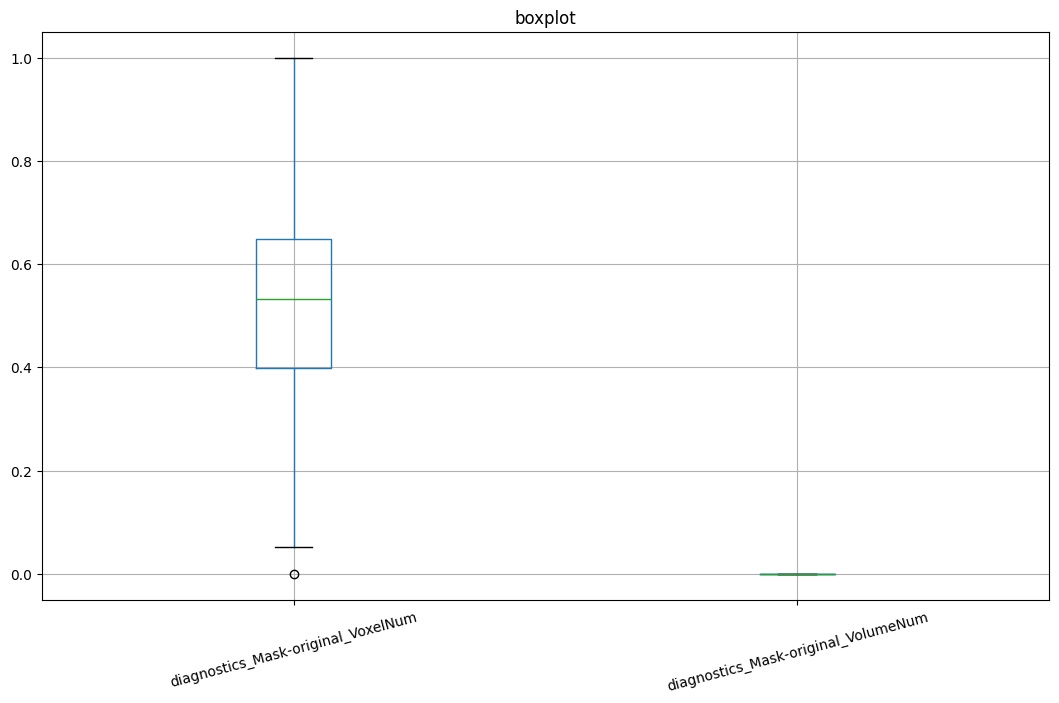

       diagnostics_Mask-original_VoxelNum  diagnostics_Mask-original_VolumeNum
count                          305.000000                                305.0
mean                          6714.790164                                  2.0
std                           1066.815670                                  0.0
min                           3609.000000                                  2.0
25%                           5941.000000                                  2.0
50%                           6723.000000                                  2.0
75%                           7396.000000                                  2.0
max                           9453.000000                                  2.0 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 5 columns):
 #   Column                                       Non-Null Count  Dtype 
---  ------                                       --------------  ----- 
 0   diagnostics_Mask-original_Boundi

In [29]:
diagnostics_mask_explorer(control_df)
diagnostics_mask_explorer(train_df)

In [30]:
diagnostics = ["diagnostics_Mask-original_Spacing","diagnostics_Mask-original_Size","diagnostics_Mask-original_BoundingBox","diagnostics_Mask-original_VoxelNum","diagnostics_Mask-original_VolumeNum","diagnostics_Mask-original_CenterOfMassIndex","diagnostics_Mask-original_CenterOfMass","diagnostics_Image-original_Spacing","diagnostics_Image-original_Size","diagnostics_Image-original_Mean","diagnostics_Image-original_Maximum"]
def masks_images_correlation(df):
    show_heatmap(df=df[diagnostics])   

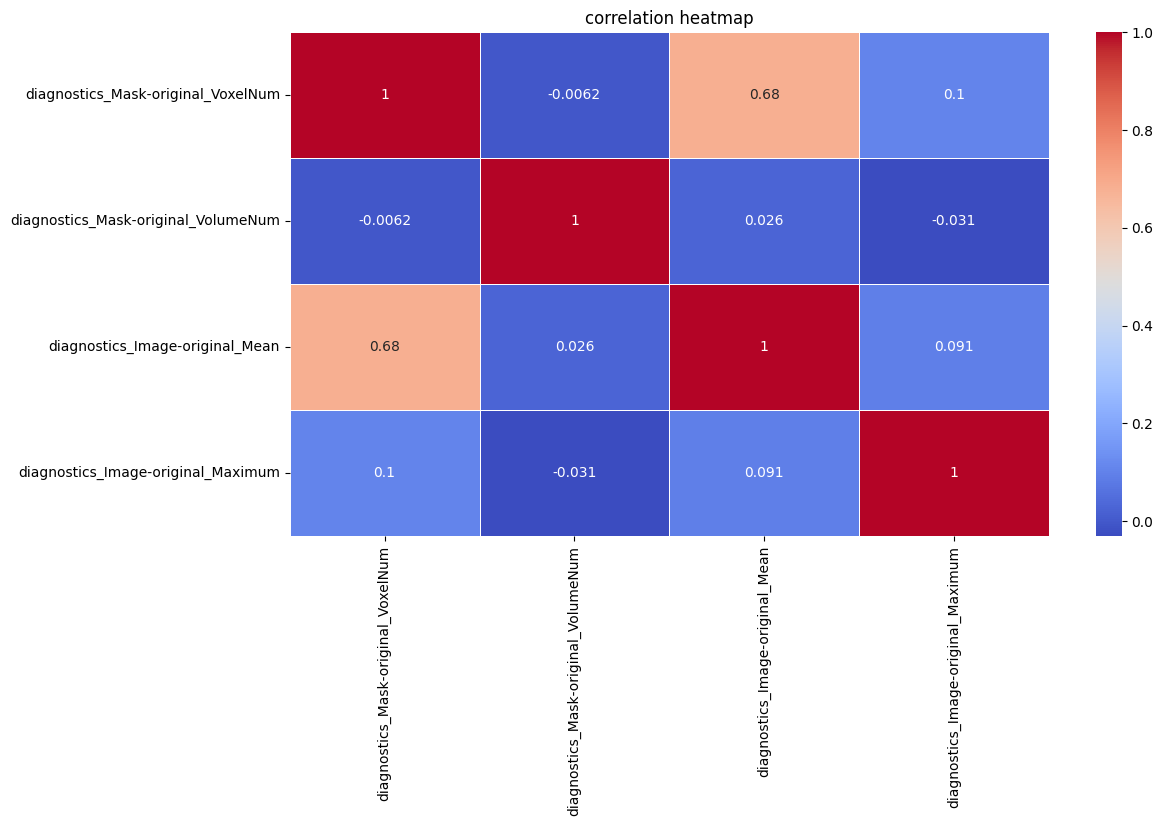

In [31]:
masks_images_correlation(control_df)

## Drop Unnecessary Columns

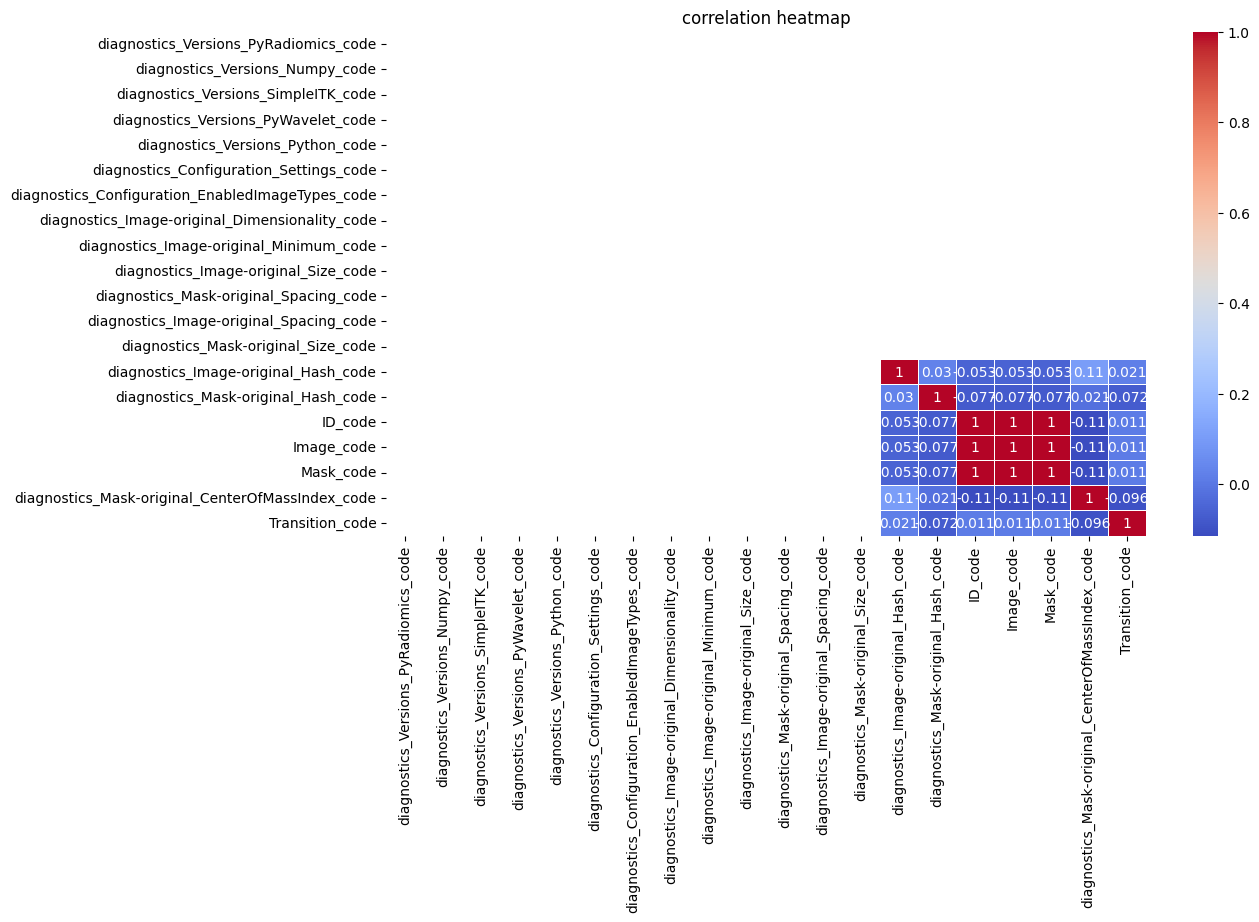

In [32]:
unnecessary_columns = diagnostics_versions_columns + diagnostics_configs_columns +["diagnostics_Image-original_Dimensionality","diagnostics_Image-original_Minimum","diagnostics_Image-original_Size","diagnostics_Mask-original_Spacing","diagnostics_Image-original_Spacing","diagnostics_Mask-original_Size","diagnostics_Image-original_Hash","diagnostics_Mask-original_Hash","ID","Image","Mask",'diagnostics_Mask-original_CenterOfMassIndex']

unnecessary_df = pd.DataFrame()
for col in unnecessary_columns+["Transition"]:
    le_make = LabelEncoder()
    unnecessary_df[f"{col}_code"] = le_make.fit_transform(train_df[col])

show_heatmap(unnecessary_df)

In [33]:
control_df = control_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")
train_df = train_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")
test_df = test_df.drop(columns=unnecessary_columns,axis=1,errors="ignore")

In [34]:
main_exploration(train_df)

(305, 2163)


## Top Correlations Function
Esta função devolve as colunas mais/menos correlacionadas com a feature target desejada

In [35]:
def top_correlations(df, target="Transition_code",starts_with=None,number=10,ascending=False):
    if starts_with == None:
        corr_columns = df.select_dtypes(include=["int64","float64"]).columns
    else:
        corr_columns = df.columns[df.columns.str.startswith(starts_with)]

    corr_matrix = df[corr_columns].corrwith(df[target])

    top_features = corr_matrix.sort_values(ascending=ascending).head(number).index.tolist()
    top_features.append(target)
    top_features = pd.Index(top_features)
    
    return top_features

corr_columns = train_df.select_dtypes(include=["int64","float64"]).columns
corr_matrix = train_df[corr_columns].corrwith(train_df["Transition_code"])


C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


## Nunique Columns PreProcessing

C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\carlo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


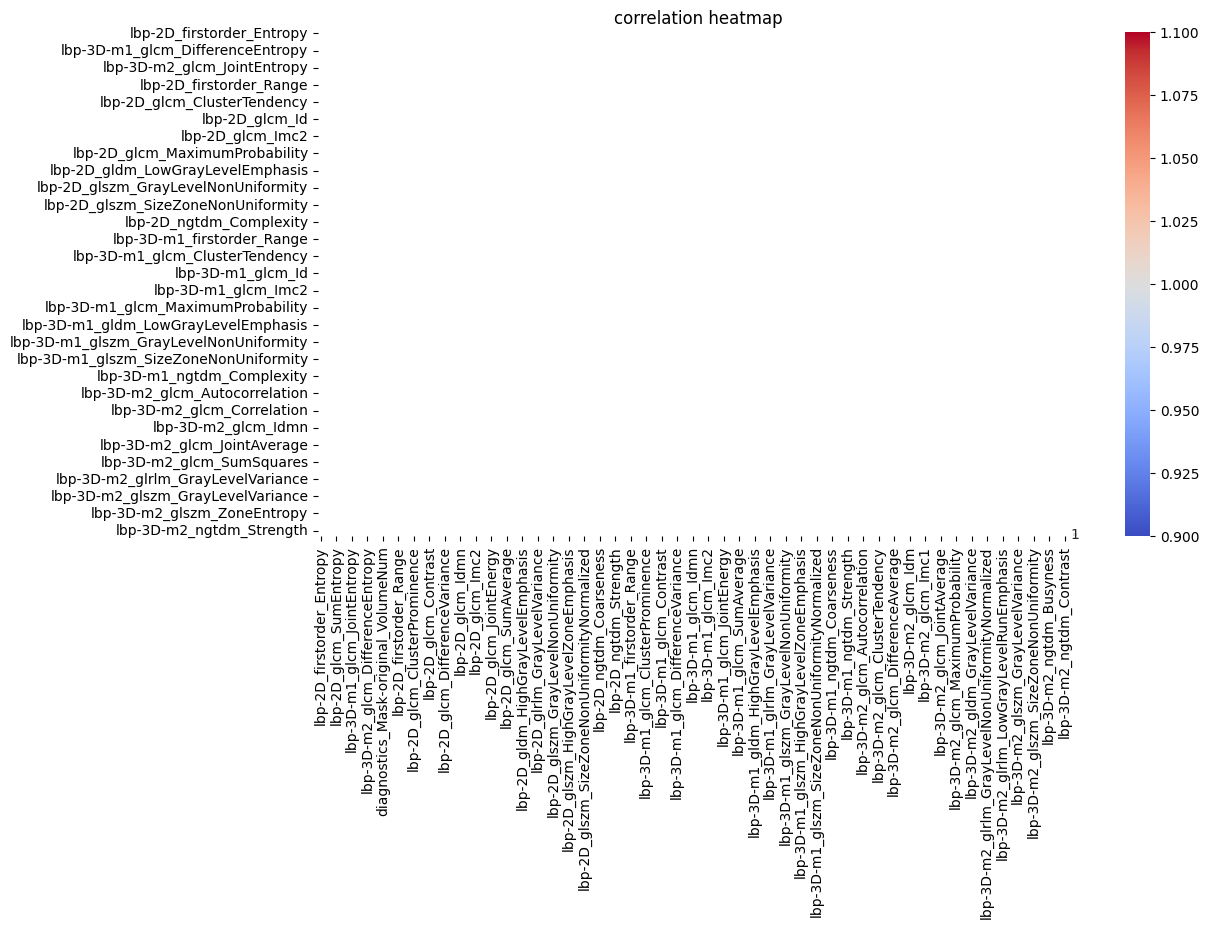

(305, 2163)
(305, 2163)
(100, 2161)


In [36]:
nunique_columns = train_df.columns[train_df.nunique() == 1].tolist()
nunique_columns.append("Transition_code")
nunique_corr_columns = top_correlations(train_df[nunique_columns],number=10000)

show_heatmap(train_df[nunique_corr_columns])

main_exploration(train_df)
main_exploration(control_df)
main_exploration(test_df)

nunique_columns.remove("Transition_code")
train_df = train_df.drop(columns=nunique_columns, errors="ignore")
test_df = test_df.drop(columns=nunique_columns, errors="ignore")
control_df = control_df.drop(columns=nunique_columns, errors="ignore")


## Non Numeric Exploration

In [37]:
def non_numeric_exploration(df):
    non_numeric_columns = train_df.select_dtypes(exclude=['int64', 'float64']).columns
    return non_numeric_columns

In [38]:
non_numeric_columns = non_numeric_exploration(train_df)
print(train_df[non_numeric_columns].head())

  diagnostics_Mask-original_BoundingBox  \
0            (103, 113, 93, 36, 30, 71)   
1             (81, 127, 93, 47, 16, 73)   
2             (77, 119, 89, 49, 30, 81)   
3             (93, 102, 90, 41, 29, 78)   
4             (87, 119, 91, 40, 27, 75)   

              diagnostics_Mask-original_CenterOfMass Transition  \
0  (121.94230227976358, 129.27272727272728, 128.4...      CN-CN   
1  (107.06170458927883, 135.28088443244633, 128.2...      CN-CN   
2  (103.3640972118682, 135.28164604144922, 128.98...      AD-AD   
3  (116.29827315541601, 118.67431469629271, 129.3...     CN-MCI   
4  (108.26561977948546, 132.05462746408287, 127.6...      CN-CN   

   Transition_code  
0                1  
1                1  
2                0  
3                2  
4                1  


## Non Numerical Columns PreProcessing

In [39]:
# Separar a coluna de BoundingBox em várias colunas
train_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = train_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)


# Separar a coluna de CenterOfMassIndex em várias colunas
train_df[['x_center', 'y_center', 'z_center']] = train_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [40]:
# Separar a coluna de BoundingBox em várias colunas
test_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = test_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)


# Separar a coluna de CenterOfMassIndex em várias colunas
test_df[['x_center', 'y_center', 'z_center']] = test_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [41]:
# Separar a coluna de BoundingBox em várias colunas
control_df[['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra']] = control_df['diagnostics_Mask-original_BoundingBox'].str.strip('()').str.split(',', expand=True).astype(float)


# Separar a coluna de CenterOfMassIndex em várias colunas
control_df[['x_center', 'y_center', 'z_center']] = control_df['diagnostics_Mask-original_CenterOfMass'].str.strip('()').str.split(',', expand=True).astype(float)

In [42]:
train_df = train_df.drop(['diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")
test_df = test_df.drop(['diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")
control_df = control_df.drop(['diagnostics_Mask-original_BoundingBox', 'diagnostics_Mask-original_CenterOfMass'], axis=1, errors="ignore")

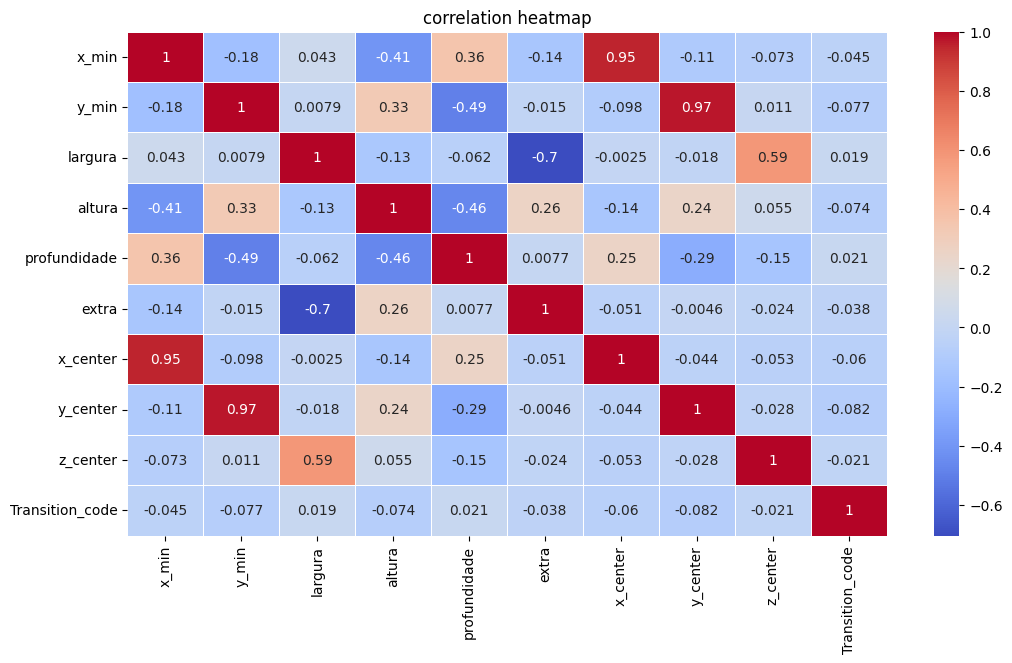

In [43]:
new_numeric_columns = ['x_min', 'y_min', 'largura', 'altura', 'profundidade', 'extra','x_center', 'y_center', 'z_center',"Transition_code"]
show_heatmap(train_df[new_numeric_columns])


## Numeric Diagnostics Corr

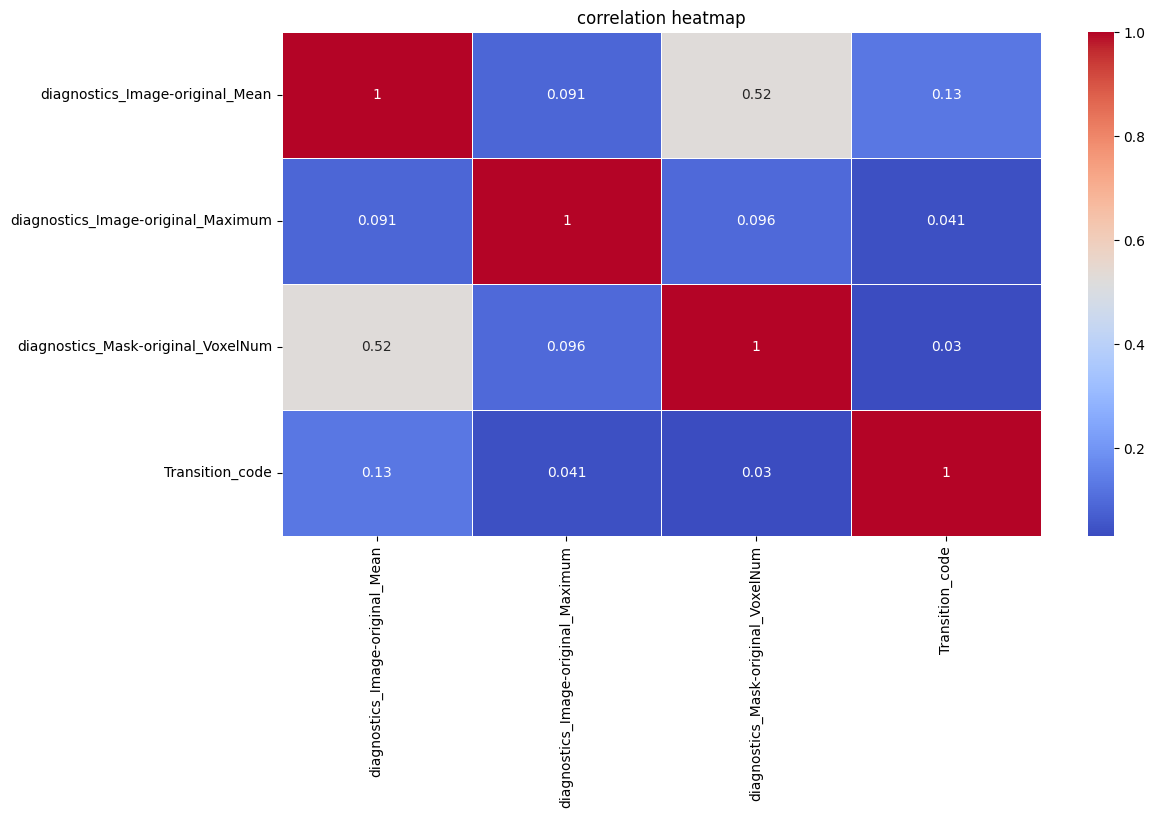

In [44]:
diagnostics_corr = top_correlations(train_df, starts_with="diagnostics")
show_heatmap(train_df[diagnostics_corr])

## Radiomics

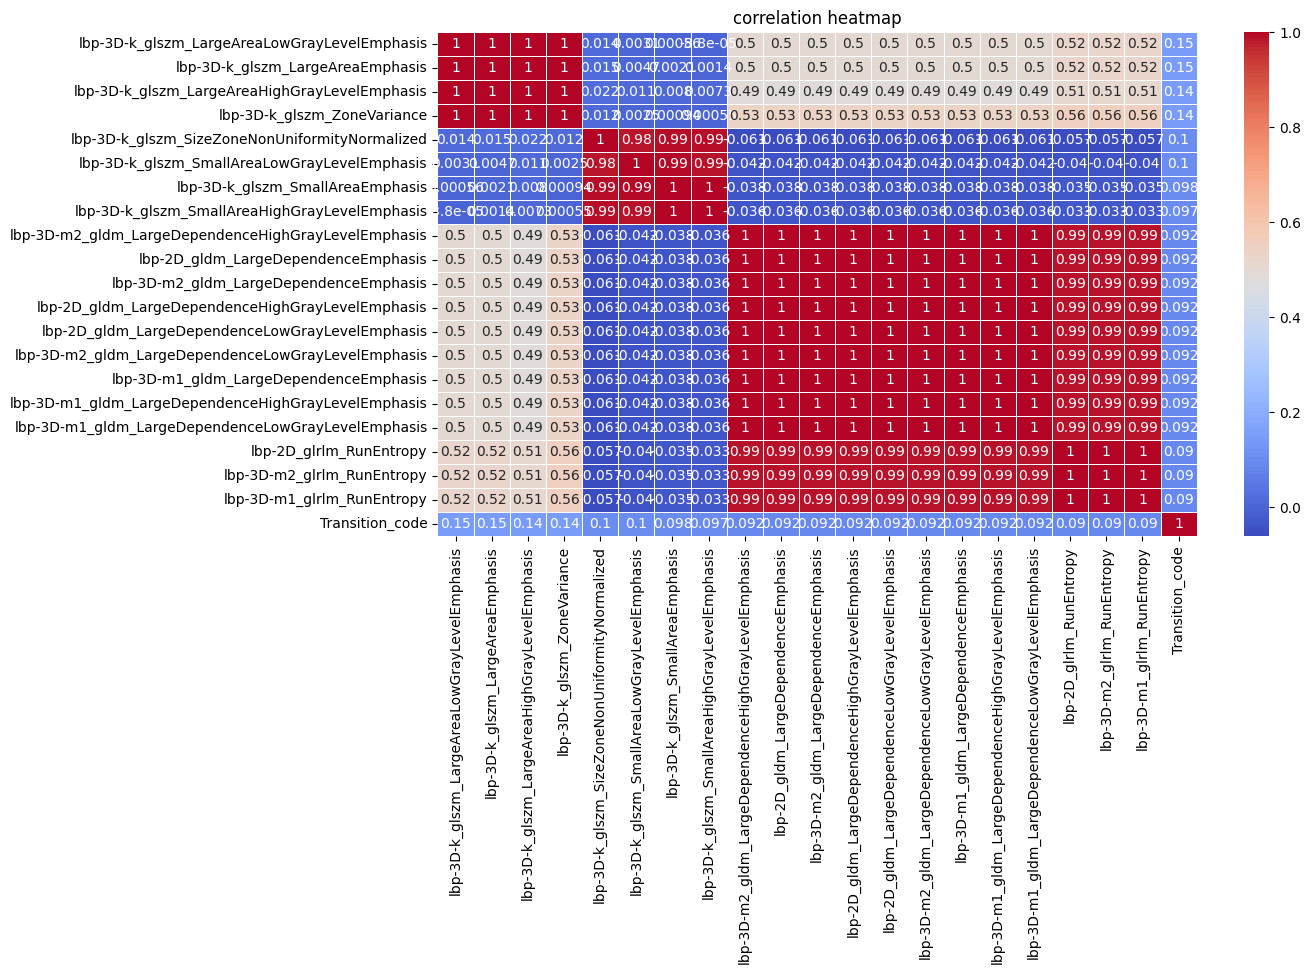

In [45]:
rad_corr = top_correlations(train_df,starts_with="lbp",number=20)
show_heatmap(train_df[rad_corr])

## Top Correlations
Retorna as X colunas com melhor correlação com o nosso target

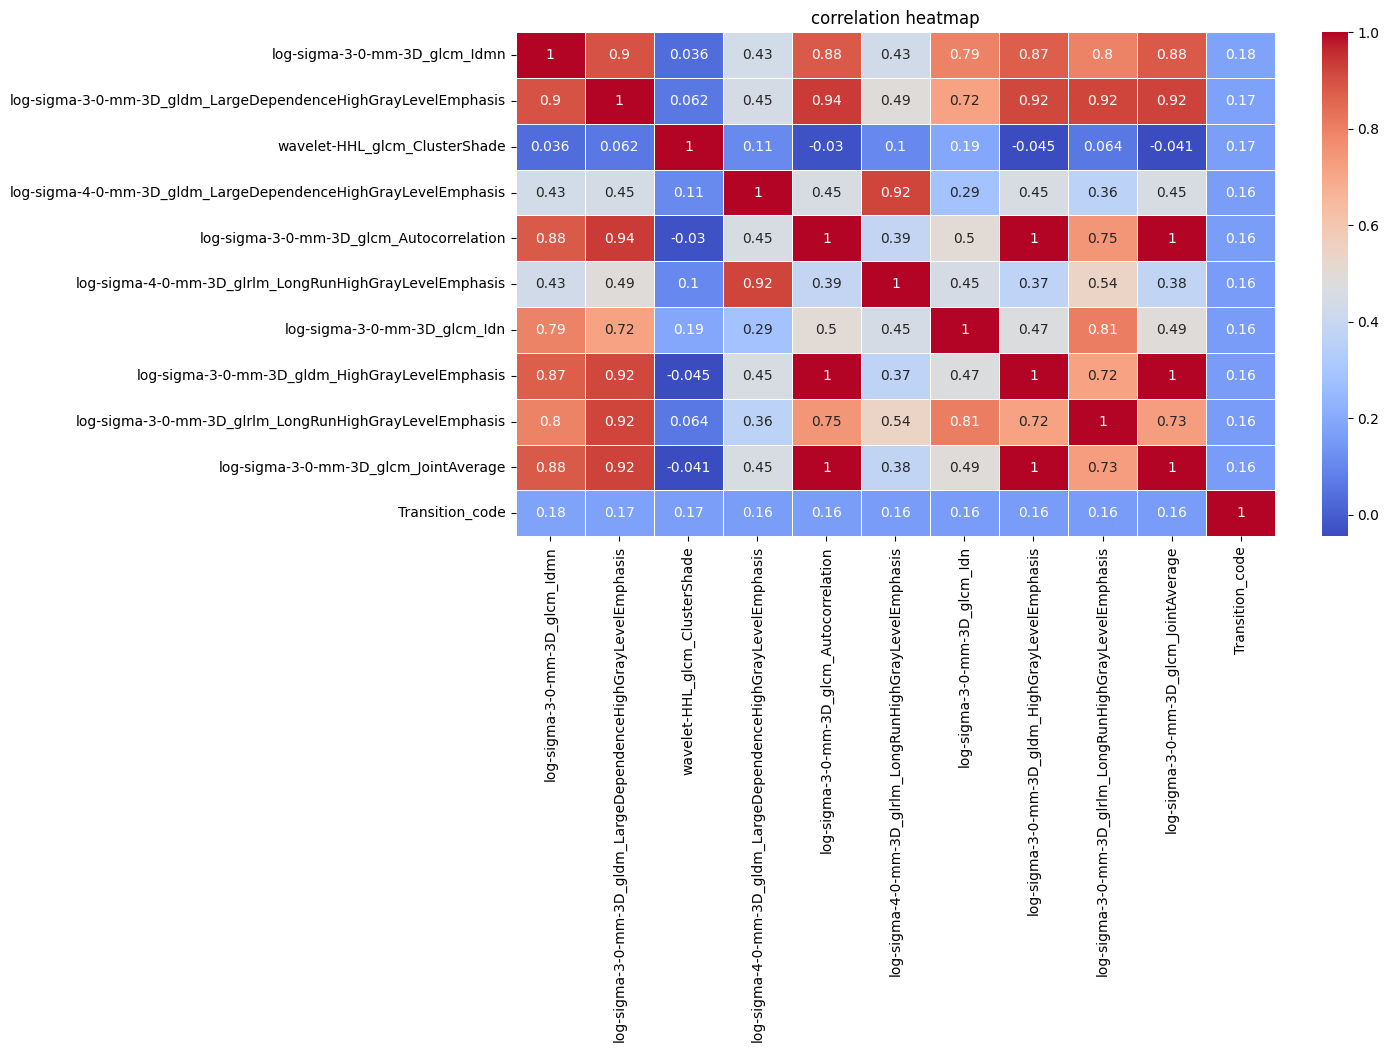

In [46]:
top_features = top_correlations(train_df)
show_heatmap(train_df[top_features])

# Data Processing

## Very Low Correlations Processing
Estas colunas têm um valor de correlação com o target tão baixo que podem ser praticamente dispensadas

In [47]:
low_corr_columns_absolute = corr_matrix[(corr_matrix.abs() < 0.05)].index.tolist() 
low_corr_columns = corr_matrix[(corr_matrix < 0.05)].index.tolist()
print(len(low_corr_columns_absolute))
print(len(low_corr_columns))

1286
1677


In [48]:
low_corr_train_df = train_df.drop(columns=low_corr_columns,axis=1,errors="ignore")
low_corr_control_df = control_df.drop(columns=low_corr_columns,axis=1,errors="ignore")
low_corr_test_df = test_df.drop(columns=low_corr_columns,axis=1,errors="ignore")

low_corr_abs_train_df = train_df.drop(columns=low_corr_columns_absolute,axis=1,errors="ignore")
low_corr_abs_control_df = control_df.drop(columns=low_corr_columns_absolute,axis=1,errors="ignore")
low_corr_abs_test_df = test_df.drop(columns=low_corr_columns_absolute,axis=1,errors="ignore")

In [49]:
main_exploration(low_corr_train_df)
main_exploration(low_corr_control_df)
main_exploration(low_corr_test_df)
print("---low---")
main_exploration(low_corr_abs_train_df)
main_exploration(low_corr_abs_control_df)
main_exploration(low_corr_abs_test_df)

(305, 359)
(305, 359)
(100, 357)
---low---
(305, 750)
(305, 750)
(100, 748)


## Data Scaler
Padroniza os dados

In [50]:
from sklearn.preprocessing import StandardScaler

def data_scaler(df):
    scaler_df = df.drop(columns=["Transition","Transition_code"],errors="ignore")
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(scaler_df),columns=scaler_df.columns)
    return df_scaled


In [51]:
scaled_train_df = data_scaler(train_df)
scaled_control_df = data_scaler(control_df)
scaled_test_df = data_scaler(test_df)

## Data Normalizer
Normalizar dados

In [52]:
from sklearn.preprocessing import MinMaxScaler

def data_normalizer(df):
    scaler_df = df.drop(columns=["Transition","Transition_code"],errors="ignore")
    
    scaler = MinMaxScaler()
    df_normalized = pd.DataFrame(scaler.fit_transform(scaler_df), columns=scaler_df.columns)
    
    return df_normalized

In [53]:
normalized_train_df = data_normalizer(train_df)
normalized_control_df = data_normalizer(control_df)
normalized_test_df = data_normalizer(test_df)

## Correlation, PCA, XGBoost combine Processing
Neste teste combinamos os métodos realizados em cima de modo a tentar combinar as vantagens de cada um para obter um dataset mais reduzido apenas com as features que mais contribuem para o target 

In [54]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from xgboost import XGBClassifier

In [55]:
corr_xgb_df = scaled_train_df
corr_xgb_df.loc[:,"Transition_code"] = train_df["Transition_code"].values

target = "Transition_code"
X_corr_pca = corr_xgb_df.drop(columns=[target])
y_corr_pca = corr_xgb_df[target]

### Correlation Analisys

In [56]:
def apply_correlation(df,threshold=0.03):
    df = df.drop(columns=["Transition"],errors="ignore")
    correlation = df.corr()[target].abs().sort_values(ascending=False)
    important_features = correlation[correlation > threshold].index.tolist()
    
    if target in important_features:
        important_features.remove(target)

    return important_features


### XGBoost

In [57]:
def apply_xgboost(important_features, threshold=0.0015):
    X_filtered = X_corr_pca[important_features]
    X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_corr_pca, test_size=0.3, random_state=42)
    
    model = XGBClassifier()
    model.fit(X_train, y_train)
    
    importances = model.feature_importances_
    importance_df = pd.DataFrame({'feature': important_features, 'importance': importances})
    important_features_xgb = importance_df[importance_df['importance'] > threshold]['feature'].tolist()

    return important_features_xgb

### Apply Corr and XGB

In [58]:
corr_important_features = apply_correlation(corr_xgb_df)
corr_xgb_important_features = apply_xgboost(corr_important_features)

In [59]:
corr_xgb_train_df = scaled_train_df[corr_xgb_important_features]
corr_xgb_control_df = scaled_control_df[corr_xgb_important_features]
corr_xgb_test_df = scaled_test_df[corr_xgb_important_features]

In [60]:
print("Important: ",len(corr_important_features))
print("Important XGBoost:",len(corr_xgb_important_features))

main_exploration(corr_xgb_train_df)
main_exploration(corr_xgb_control_df)
main_exploration(corr_xgb_test_df)

Important:  1268
Important XGBoost: 157
(305, 157)
(305, 157)
(100, 157)


### PCA

In [61]:
def apply_pca(train_df,control_df,test_df,n_components=50):
    pca = PCA(n_components=n_components)

    train_df.drop(columns=["Transition","Transition_code"],errors="ignore",inplace=True)
    control_df.drop(columns=["Transition","Transition_code"],errors="ignore",inplace=True)
    test_df.drop(columns=["Transition","Transition_code"],errors="ignore",inplace=True)
    
    X_train_pca = pca.fit_transform(train_df)
    X_control_pca = pca.transform(control_df)
    X_test_pca = pca.transform(test_df)

    X_train_pca_df = pd.DataFrame(X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_pca.shape[1])])
    X_control_pca_df = pd.DataFrame(X_control_pca, columns=[f'PC{i+1}' for i in range(X_control_pca.shape[1])])
    X_test_pca_df = pd.DataFrame(X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_pca.shape[1])])

    return X_train_pca_df, X_control_pca_df, X_test_pca_df

### Apply PCA to Corr and XGB

In [62]:
corr_xgb_pca_train_df,  corr_xgb_pca_control_df, corr_xgb_pca_test_df = apply_pca(corr_xgb_train_df,corr_xgb_control_df,corr_xgb_test_df)

C:\Users\carlo\AppData\Local\Temp\ipykernel_17356\4289421417.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(columns=["Transition","Transition_code"],errors="ignore",inplace=True)
C:\Users\carlo\AppData\Local\Temp\ipykernel_17356\4289421417.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  control_df.drop(columns=["Transition","Transition_code"],errors="ignore",inplace=True)
C:\Users\carlo\AppData\Local\Temp\ipykernel_17356\4289421417.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/panda

In [63]:
main_exploration(corr_xgb_pca_train_df)
main_exploration(corr_xgb_pca_control_df)
main_exploration(corr_xgb_pca_test_df)

(305, 50)
(305, 50)
(100, 50)


### Add Transition_code to DataSets

In [64]:
corr_xgb_train_df.loc[:,"Transition_code"] = train_df["Transition_code"].values
corr_xgb_control_df.loc[:,"Transition_code"] = control_df["Transition_code"].values
corr_xgb_pca_train_df.loc[:,"Transition_code"] = train_df["Transition_code"].values
corr_xgb_pca_control_df.loc[:,"Transition_code"] = control_df["Transition_code"].values

C:\Users\carlo\AppData\Local\Temp\ipykernel_17356\2885228922.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_xgb_train_df.loc[:,"Transition_code"] = train_df["Transition_code"].values
C:\Users\carlo\AppData\Local\Temp\ipykernel_17356\2885228922.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  corr_xgb_control_df.loc[:,"Transition_code"] = control_df["Transition_code"].values


In [65]:
main_exploration(corr_xgb_pca_train_df)
main_exploration(corr_xgb_pca_control_df)
main_exploration(corr_xgb_pca_test_df)

(305, 51)
(305, 51)
(100, 50)


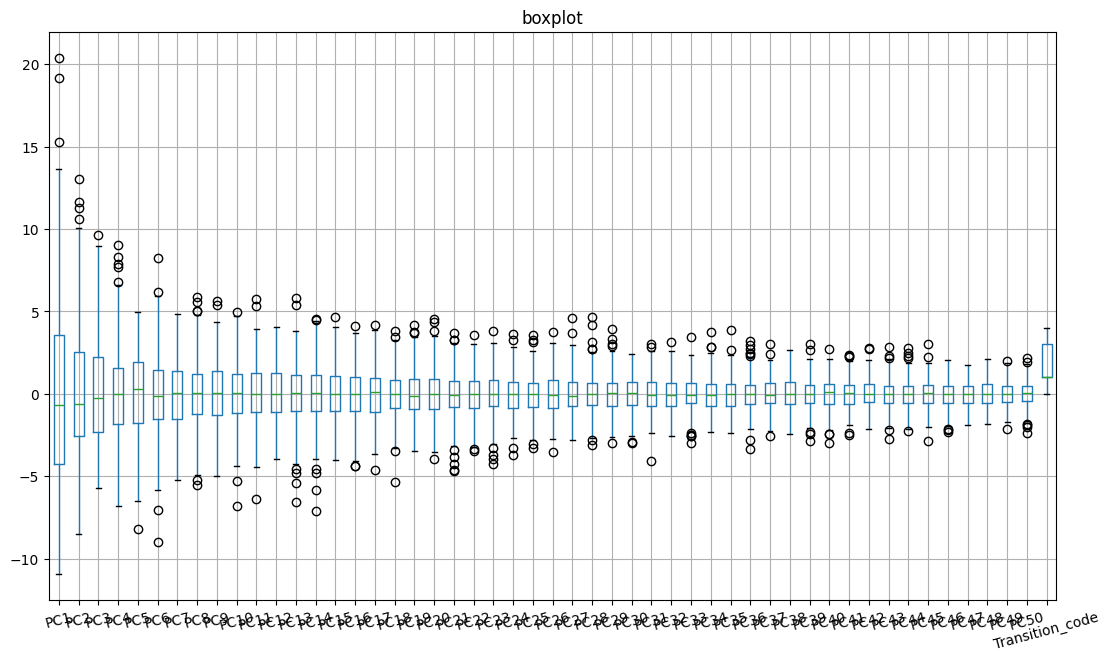

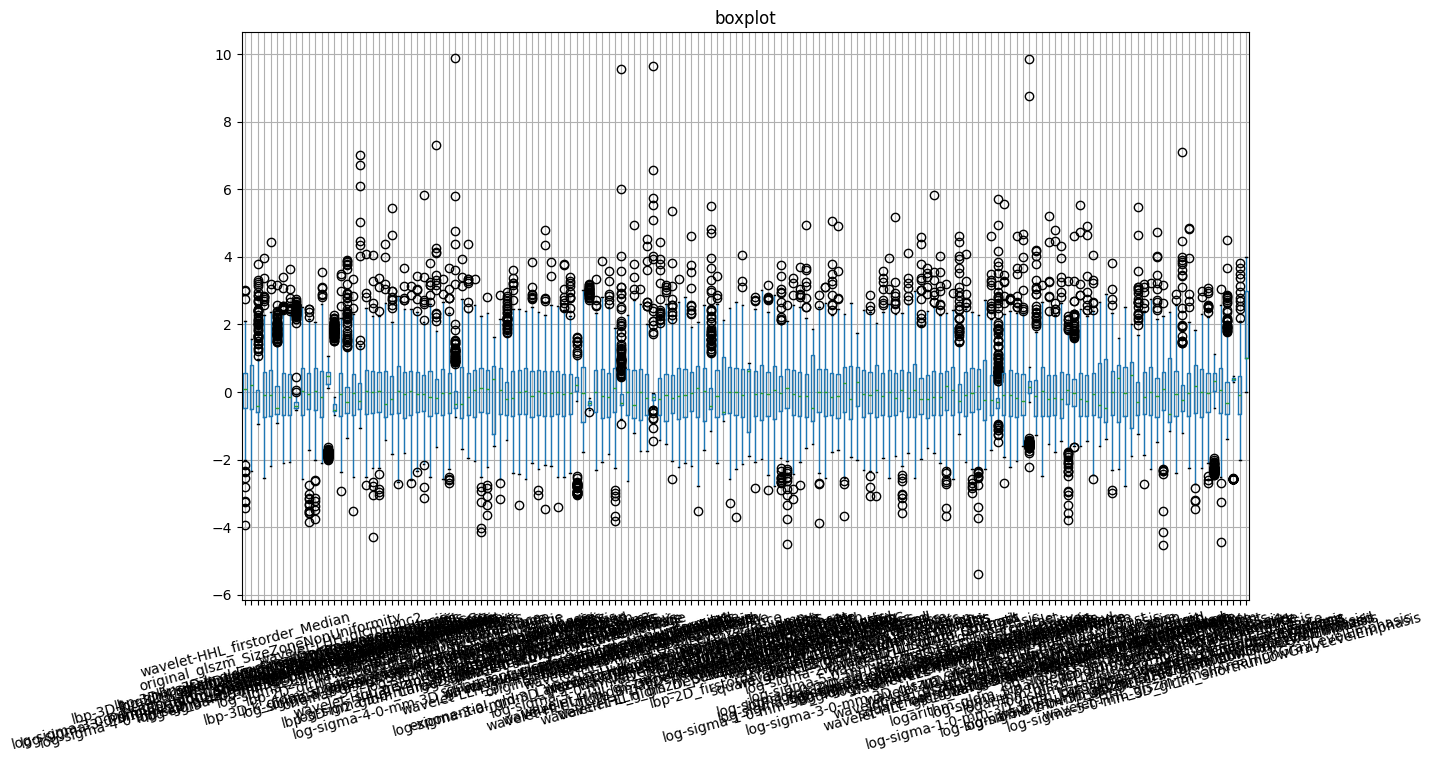

In [66]:
show_boxplot(corr_xgb_pca_train_df)
show_boxplot(corr_xgb_train_df)

## Importante
!!Não Esquecer!!

Para já vamos tentar aplicar este métodos de processamento de dados usando o `StandardScaler`. Mas eventualmente nos testes vamos tentar as duas abordagens. 

# Testing Phase

## ML Models

In [67]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from xgboost import XGBClassifier

In [75]:
def define_X_y(train_df, test_df = pd.DataFrame()):
    if test_df.empty:
        X = train_df.drop(columns=["Transition_code","Transition"],errors="ignore")
        y = train_df["Transition_code"]

        x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=27)

        return x_train, x_test, y_train, y_test

    else:
        x_train = train_df.drop("Transition_code",axis=1,errors="ignore")
        y_train = train_df["Transition_code"]
        x_test = test_df

        return x_train, x_test, y_train, None

In [76]:
x_train, x_test, y_train, y_test = define_X_y(train_df)

main_exploration(x_train)
main_exploration(x_test)

(244, 2022)
(61, 2022)


### Random Forest w/ GridSearch Cross Validation

In [77]:
def random_forest(x_train, y_train):
    random_forest = RandomForestClassifier(random_state=27)

    param_grid = {
        'n_estimators': [100, 200, 400],
        'max_depth': [None, 10, 20, 30, 50],
        'min_samples_split': [2, 5, 10, 15],
        'min_samples_leaf': [1, 2, 4, 6],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    }

    # não usado para já, muito lento, apenas durante a noite
    grid_search = GridSearchCV(
        estimator=random_forest,
        param_grid=param_grid,
        cv=5,  
        scoring='f1_macro', 
        n_jobs=-1 
    )

    grid_search_random = RandomizedSearchCV(
        estimator=random_forest,
        param_distributions=param_grid,
        n_iter=100,         
        cv=5,
        scoring='f1_macro',
        n_jobs=-1,
        random_state=27
    )
    
    grid_search_random.fit(x_train, y_train)

    print(f"Melhores parâmetros: {grid_search_random.best_params_}")

    best_model = grid_search_random.best_estimator_

    return best_model  

In [78]:
random_forest_model = random_forest(x_train, y_train)

Melhores parâmetros: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}


In [79]:
random_forest_pred = random_forest_model.predict(x_test)

In [80]:
f1_macro_score_rf = f1_score(y_test, random_forest_pred, average="macro")
print(f"F1 Macro Score na melhor combinação de parametros: {f1_macro_score_rf:.2f}")  

F1 Macro Score na melhor combinação de parametros: 0.28


### XGBoost w/ GridSearch Cross Validation

In [81]:
def xgboost_model(x_train,y_train):
    xgb_model = XGBClassifier(eval_metric="mlogloss",random_state=27)


    param_grid = {
        'n_estimators': [100, 200, 400],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.2],
        'reg_alpha': [0, 0.01, 0.1],
        'reg_lambda': [1, 1.5, 2]
    }
    
    # não usado para já, muito lento, apenas durante a noite
    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        cv=5,  
        scoring='f1_macro',
        n_jobs=-1
    )

    grid_search_random = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_grid,
        n_iter=100,         
        cv=5,
        scoring='f1_macro',
        n_jobs=-1,
        random_state=27
    )


    grid_search_random.fit(x_train,y_train)

    print(f"Melhores parâmetros: {grid_search_random.best_params_}")

    best_model = grid_search_random.best_estimator_

    return best_model

In [82]:
xgb_model = xgboost_model(x_train, y_train)

KeyboardInterrupt: 

In [ ]:
xgb_pred = xgb_model.predict(x_test)

In [ ]:
f1_macro_score_xgb = f1_score(y_test, xgb_pred, average="macro")
print(f"F1 Macro Score na melhor combinação de parametros: {f1_macro_score_xgb:.2f}")

## Ensemble Learning (RandomForest w/ XGBoost)

### Voting Classifier

In [ ]:
def ensemble_voting_classifier(x_train,y_train,rf_best_model,xgb_best_model):
    ensemble_model = VotingClassifier(
        estimators = [
            ("random_forest",rf_best_model),
            ("xgboost",xgb_best_model)
        ],
        voting="soft",
        weights=[1,1]
    )

    ensemble_model.fit(x_train, y_train)

    
    return ensemble_model

In [ ]:
ensemble_voting_model = ensemble_voting_classifier(x_train,y_train,random_forest_model,xgb_model)

In [ ]:
ensemble_voting_pred = ensemble_voting_model.predict(x_test)

In [ ]:
f1_macro_score_voting_ensemble = f1_score(y_test, ensemble_voting_pred, average="macro")
print(f"F1 Macro Score com ensemble: {f1_macro_score_voting_ensemble:.2f}")

### Stacking Classifier

In [ ]:
def ensemble_stacking_classifier(x_train,y_train,rf_best_model,xgb_best_model):
    ensemble_model = StackingClassifier(
        estimators = [
            ("random_forest",rf_best_model),
            ("xgboost",xgb_best_model)
        ],
        final_estimator=LogisticRegression(),
        cv=5,
    )

    ensemble_model.fit(x_train, y_train)

    return ensemble_model

In [ ]:
ensemble_stacking_model = ensemble_stacking_classifier(x_train,y_train,random_forest_model,xgb_model)

In [ ]:
ensemble_stacking_pred = ensemble_stacking_model.predict(x_test)

In [ ]:
f1_macro_score_stacking_ensemble = f1_score(y_test, ensemble_stacking_pred, average="macro")
print(f"F1 Macro Score com ensemble: {f1_macro_score_stacking_ensemble:.2f}")

### Scores

## Write Predicts to CSV

In [ ]:
def preds_to_csv(preds, df=dummy_df):
    if len(preds) == 100:
        y_pred_original = target_decoder(le_make_train, preds)
        
        df["Result"] = y_pred_original
        
        df.to_csv("../Dataset/dummy_submission.csv", index=False)

        print("CSV updated!\n", y_pred_original)

In [ ]:
preds_to_csv(xgb_pred)